In [37]:
# Standard library imports
import argparse
import json
import os
import sys
from datetime import date, datetime, time as dtime
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from urllib.parse import urlencode

# Third-party imports
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
import seaborn as sns
from dotenv import load_dotenv
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from scipy.optimize import curve_fit

# ---------------------------------
# Config
# ---------------------------------
PHASE_CHANGES = '../data/phase_change_data.csv'
RAW_DATA = '../data/raw_data_all_locations.csv'
DAILY_SUMS = '../data/daily_summaries_all_locations.csv'
BIRDCAST_PARQUET = '../../birdcast-data-grabber/data/birdcast_data.parquet'
BIRDCAST_CSV = '../../birdcast-data-grabber/data/birdcast_data.csv'
load_dotenv()

# Time-binning config
TIME_BIN_START_HOUR = 0     # 6 AM
TIME_BIN_END_HOUR = 23      # 8 PM (20 in 24h)
TIME_BIN_MINUTES = 30       # 30-minute bins

# Plot config
PLOTLY_RENDERER = 'browser'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# ---------------------------------
# Dashboard Export Functions
# ---------------------------------
# Create dashboard output directory
DASHBOARD_DIR = '../docs/dashboard_plots'
os.makedirs(DASHBOARD_DIR, exist_ok=True)
os.makedirs(f'{DASHBOARD_DIR}/images', exist_ok=True)
os.makedirs(f'{DASHBOARD_DIR}/interactive', exist_ok=True)

print(f"Dashboard plots will be saved to: {DASHBOARD_DIR}")

# Function to save matplotlib plots
def save_plot_for_dashboard(fig, filename, title, description=""):
    """Save matplotlib figure for dashboard with metadata."""
    # Save as high-res PNG
    png_path = f'{DASHBOARD_DIR}/images/{filename}.png'
    fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Create metadata file
    metadata = {
        'title': title,
        'description': description,
        'filename': filename,
        'type': 'matplotlib',
        'created': datetime.now().isoformat(),
        'image_path': f'images/{filename}.png'
    }
    
    with open(f'{DASHBOARD_DIR}/{filename}.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Saved: {title} -> {filename}")
    return filename

Dashboard plots will be saved to: ../docs/dashboard_plots


In [38]:
# ---------------------------------
# Helpers for time-binning & plots
# ---------------------------------
def build_time_bins(start_hour: int = TIME_BIN_START_HOUR,
                    end_hour: int = TIME_BIN_END_HOUR,
                    step_minutes: int = TIME_BIN_MINUTES) -> Tuple[List[dtime], List[str]]:
    time_bins: List[dtime] = []
    for hour in range(start_hour, end_hour + 1):
        for minute in range(0, 60, step_minutes):
            if hour == end_hour and minute >= 60:
                break
            time_bins.append(dtime(hour, minute))
    time_labels = [t.strftime('%I:%M %p') for t in time_bins]
    return time_bins, time_labels


def assign_time_bin_factory(time_bins: List[dtime]):
    # Returns a function that maps a datetime.time -> index of its bin
    def assign_time_bin(t):
        if t is None or pd.isna(t):
            return None
        t_minutes = t.hour * 60 + t.minute
        for i, bin_time in enumerate(time_bins):
            bin_minutes = bin_time.hour * 60 + bin_time.minute
            if t_minutes < bin_minutes + TIME_BIN_MINUTES:
                return i
        return len(time_bins) - 1
    return assign_time_bin


def prepare_complete_data(raw_df: pd.DataFrame,
                          time_bins: List[dtime]) -> Tuple[pd.DataFrame, List[str], list, list, pd.DataFrame]:
    # Ensure Time column is datetime.time
    if not np.issubdtype(pd.Series(raw_df['Time']).dtype, np.dtype('O')):
        raw_df = raw_df.copy()
        raw_df['Time'] = pd.to_datetime(raw_df['Time'], format='%H:%M:%S').dt.time

    time_bins, time_labels = build_time_bins()
    assign_time_bin = assign_time_bin_factory(time_bins)

    df = raw_df.copy()
    df['TimeBin'] = pd.to_datetime(df['Time']).apply(assign_time_bin)
    df = df.dropna(subset=['TimeBin'])

    grouped_data = df.groupby(['Date', 'TimeBin']).size().reset_index(name='Count')

    all_dates = sorted(df['Date'].unique())
    all_time_bins = list(range(len(time_bins)))

    complete_grid = pd.DataFrame([(date, tb) for date in all_dates for tb in all_time_bins],
                                 columns=['Date', 'TimeBin'])

    complete_data = complete_grid.merge(grouped_data, on=['Date', 'TimeBin'], how='left').fillna(0)

    dates = sorted(complete_data['Date'].unique())
    time_bin_indices = sorted(complete_data['TimeBin'].unique())
    return complete_data, time_labels, dates, time_bin_indices, grouped_data

def plot_heatmap_counts_subplots(location_data: dict,
                                title: str = 'Heatmap: Date vs Time of Day vs Observation Count') -> None:
    locations = sorted(list(location_data.keys())) 
    n_locations = len(locations)
    
    fig, axes = plt.subplots(1, n_locations, figsize=(12*n_locations, 10))
    
    # Ensure axes is always a list for consistent indexing
    if n_locations == 1:
        axes = [axes]
    
    for i, location in enumerate(locations):
        ax = axes[i]
        complete_data = location_data[location]['complete_data']
        time_labels = location_data[location]['time_labels']
        
        heatmap_data = complete_data.pivot(index='TimeBin', columns='Date', values='Count')
        
        sns.heatmap(
            heatmap_data,
            xticklabels=[d.strftime('%m/%d') for d in heatmap_data.columns],
            yticklabels=[time_labels[int(i)] for i in heatmap_data.index],
            cmap='viridis',
            cbar_kws={'label': 'Count of Observations'},
            annot=True,
            fmt='g',
            linewidths=0.5,
            ax=ax
        )
        
        ax.set_title(location, fontsize=30, fontweight='bold')
        ax.set_xlabel('Date', fontsize=24, labelpad=12)
        if i==0:
            ax.set_ylabel('Time of Day', fontsize=24, labelpad=12)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', rotation=0, labelsize=10)
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.show()
    return fig


def plot_heatmap_proportions_subplots(location_data: dict,
                                     title: str = 'Heatmap: Date vs Time of Day vs Proportion of Observations') -> None:
    locations = sorted(list(location_data.keys())) 
    n_locations = len(locations)
    
    fig, axes = plt.subplots(1, n_locations, figsize=(12*n_locations, 10))
    
    # Ensure axes is always a list for consistent indexing
    if n_locations == 1:
        axes = [axes]
    
    for i, location in enumerate(locations):
        ax = axes[i]
        complete_data = location_data[location]['complete_data']
        time_labels = location_data[location]['time_labels']
        
        complete_with_totals = complete_data.copy()
        complete_with_totals['Daily Total'] = complete_with_totals.groupby('Date')['Count'].transform('sum')
        complete_with_totals['Daily Proportion'] = (complete_with_totals['Count'] / complete_with_totals['Daily Total']).round(2)
        heatmap_data = complete_with_totals.pivot(index='TimeBin', columns='Date', values='Daily Proportion')
        
        sns.heatmap(
            heatmap_data,
            xticklabels=[d.strftime('%m/%d') for d in heatmap_data.columns],
            yticklabels=[time_labels[int(i)] for i in heatmap_data.index],
            cmap='viridis',
            cbar_kws={'label': 'Proportion of Observations'},
            annot=True,
            fmt='g',
            linewidths=0.5,
            ax=ax
        )
        
        ax.set_title(location, fontsize=30, fontweight='bold')
        ax.set_xlabel('Date', fontsize=24, labelpad=12)
        if i==0:
            ax.set_ylabel('Time of Day', fontsize=24, labelpad=12)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', rotation=0, labelsize=10)
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.show()
    return fig

In [39]:
# Load data
raw_data = pd.read_csv(RAW_DATA)
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

daily_summs = pd.read_csv(DAILY_SUMS)
daily_summs['Date'] = pd.to_datetime(daily_summs['Date'])

phase_changes = pd.read_csv(PHASE_CHANGES)

# Source Sheet dicts for renaming
locations_dict = {
    'southampton_uk': 'Southampton, UK',
    'jacksonville_fl_32259': 'Jacksonville, FL',
    'essex_fells_nj_07021': 'Essex Fells, NJ',
}
raw_data['source_sheet'] = raw_data['source_sheet'].map(locations_dict)

locations_dict = {
    'Southampton daily summaries': 'Southampton, UK',
    'Jacksonville, FL 32259 Daily Su': 'Jacksonville, FL',
    'Essex Fells, NJ 07021 Daily Sum': 'Essex Fells, NJ',
}
daily_summs['source_sheet'] = daily_summs['source_sheet'].map(locations_dict)

# Basic plots of the action

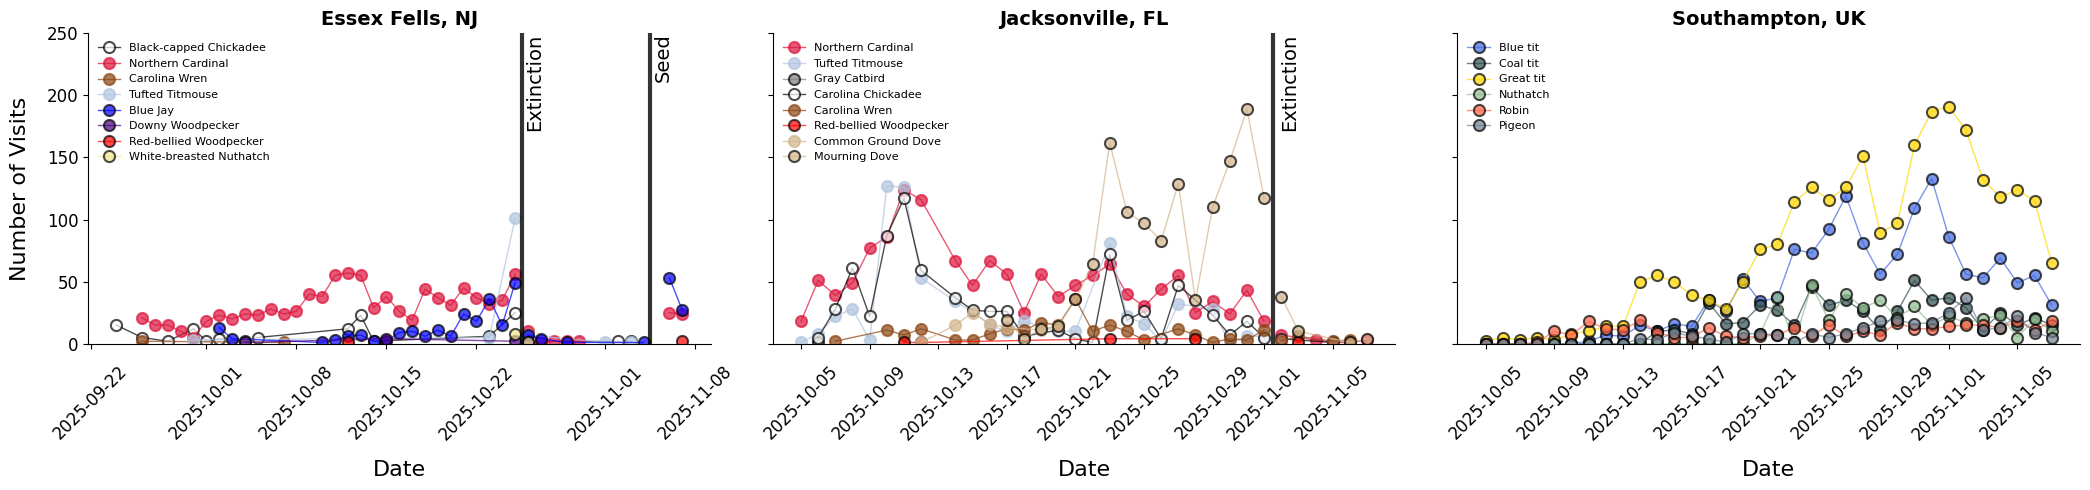


All birds have predefined colors.


In [40]:
# Define custom colors for each bird species
bird_colors = {
    'Northern Cardinal': '#DC143C',         # Cardinal red
    'Tufted Titmouse': '#B0C4DE',           # Light blue gray
    'Gray Catbird': '#808080',              # Gray
    'Carolina Chickadee': '#FFFFFF',        # White
    'Carolina Wren': '#8B4513',             # Medium brown
    'Red-bellied Woodpecker': '#FF0000',    # Red
    'Common Ground Dove': '#D2B48C',        # Tan
    'Mourning Dove': '#D2B48C',             # Tan
    'Downy Woodpecker': '#4B0082',          # Indigo (dark blue-purple)
    'Pigeon.1': '#708090',                  # Slate gray
    'Robin': '#FF6347',                     # Tomato red-orange
    'Coal tit': '#2F4F4F',                  # Dark slate gray
    'White-breasted Nuthatch': '#F0E68C',   # Khaki (light yellow-green)
    'Black-capped Chickadee': '#FFFFFF',     # White
    'Blue tit': '#4169E1',                  # Royal blue
    'Pigeon': '#708090',                    # Slate gray
    'Blue Jay': '#0000FF',                  # Blue
    'Great tit': '#FFD700',                 # Gold
    'Nuthatch': '#8FBC8F',                  # Dark sea green
}

# Define marker edge colors for birds that need black outlines
bird_edge_colors = {
    'Northern Cardinal': '#DC143C',
    'Tufted Titmouse': '#B0C4DE',
    'Gray Catbird': 'black',
    'Carolina Chickadee': 'black',
    'Carolina Wren': '#8B4513',
    'Red-bellied Woodpecker': 'black',
    'Common Ground Dove': '#D2B48C',
    'Mourning Dove': 'black',
    'Downy Woodpecker': 'black',
    'Pigeon.1': 'black',
    'Robin': 'black',
    'Coal tit': 'black',
    'White-breasted Nuthatch': 'black',
    'Black-capped Chickadee': 'black',
    'Blue tit': 'black',
    'Pigeon': 'black',
    'Blue Jay': 'black',
    'Great tit': 'black',
    'Nuthatch': 'black',
}

# Get unique locations
locations = sorted(daily_summs['source_sheet'].unique())
n_locations = len(locations)

# Create 1x3 subplot layout
fig, axes = plt.subplots(1, n_locations, figsize=(7*n_locations, 5), sharey=True)

# Ensure axes is always a list for consistent indexing
if n_locations == 1:
    axes = [axes]

# Track birds that need specific colors
birds_needing_colors = set()

# Plot each location separately
for i, location in enumerate(locations):
    ax = axes[i]
    location_data = daily_summs[daily_summs['source_sheet'] == location].dropna(subset=['Bird'])
    
    # Check for phase changes for this location
    location_phase_changes = phase_changes[phase_changes['LocationOfChange'] == location]
    
    # Get all phase change dates sorted chronologically
    phase_change_dates = []
    if not location_phase_changes.empty:
        phase_change_dates = sorted([
            pd.to_datetime(date) 
            for date in location_phase_changes['DateChangeStarted'].unique()
        ])
    
    # Plot each bird species individually with custom colors
    for bird in location_data['Bird'].unique():
        bird_data = location_data[location_data['Bird'] == bird].copy()
        bird_data = bird_data.sort_values('Date')
        bird_data['Date'] = pd.to_datetime(bird_data['Date'])
        
        # Check if bird has predefined colors
        if bird in bird_colors:
            line_color = bird_colors[bird]
            marker_color = bird_colors[bird]
            edge_color = bird_edge_colors.get(bird, 'black')
        else:
            # Generate random colors for unknown birds
            np.random.seed(hash(bird) % 2**32)  # Consistent colors per bird
            line_color = f'#{np.random.randint(0, 0xFFFFFF):06x}'
            marker_color = line_color
            edge_color = 'black'
            birds_needing_colors.add(bird)
        
        # Special handling for Carolina Chickadee
        if (bird == 'Carolina Chickadee') or (bird == 'Black-capped Chickadee'):
            line_color = '#000000'  # Black line
            marker_color = '#FFFFFF'  # White marker
        
        # Split data at all phase changes if they exist
        if len(phase_change_dates) > 0:
            # Create segments: before first change, between changes, after last change
            segments = []
            
            # First segment: before first phase change
            first_segment = bird_data[bird_data['Date'] < phase_change_dates[0]]
            if not first_segment.empty:
                segments.append(first_segment)
            
            # Middle segments: between consecutive phase changes
            for i in range(len(phase_change_dates) - 1):
                segment = bird_data[
                    (bird_data['Date'] >= phase_change_dates[i]) & 
                    (bird_data['Date'] < phase_change_dates[i + 1])
                ]
                if not segment.empty:
                    segments.append(segment)
            
            # Last segment: after last phase change
            last_segment = bird_data[bird_data['Date'] >= phase_change_dates[-1]]
            if not last_segment.empty:
                segments.append(last_segment)
            
            # Plot each segment separately
            for seg_idx, segment in enumerate(segments):
                if not segment.empty:
                    ax.plot(
                        segment['Date'], 
                        segment['Feeder Visits'], 
                        marker='o', 
                        markersize=8,
                        markerfacecolor=marker_color,
                        markeredgecolor=edge_color,
                        markeredgewidth=1.5,
                        linewidth=1,
                        color=line_color,
                        label=bird if seg_idx == 0 else "",  # Only label first segment
                        alpha=0.7
                    )
        else:
            # No phase change, plot normally
            ax.plot(
                bird_data['Date'], 
                bird_data['Feeder Visits'], 
                marker='o', 
                markersize=8,
                markerfacecolor=marker_color,
                markeredgecolor=edge_color,
                markeredgewidth=1.5,
                linewidth=1,
                color=line_color,
                label=bird, 
                alpha=0.7
            )
    
    # Add phase change vertical lines for this location
    for _, phase_row in location_phase_changes.iterrows():
        change_date = pd.to_datetime(phase_row['DateChangeStarted'])
        description = phase_row['DescriptionOfChange']
        
        # Find the date before the change date
        location_dates = location_data['Date'].unique()
        location_dates = pd.to_datetime(location_dates)
        location_dates = np.sort(location_dates)
        
        # Find the date before the change date
        before_change_idx = np.where(location_dates < change_date)[0]
        if len(before_change_idx) > 0:
            date_before = location_dates[before_change_idx[-1]]
            # Calculate halfway point
            halfway_date = date_before + (change_date - date_before) / 2
            
            # Add vertical line
            ax.axvline(x=halfway_date, color='black', linestyle='-', linewidth=3, alpha=0.8)
            
            # Add description text
            ymax = daily_summs['Feeder Visits'].max()
            ax.text(halfway_date + pd.Timedelta(days=1), 250, description, 
                rotation=90, ha='center', va='top', fontsize=14)
    
    # Set labels and formatting for each subplot
    if i == 0:
        ax.set_ylabel('Number of Visits', fontsize=16, labelpad=12)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Date', fontsize=16, labelpad=12)
    ax.set_title(location, fontsize=14, fontweight='bold')
    
    # Set x-axis ticks (every 5th day)
    ticks = location_data['Date']
    ax.tick_params(labelsize=12)
    ax.tick_params(rotation=45, axis='x', pad=10)
    for label in ax.get_xticklabels():
        label.set_fontweight('normal')
        label.set_fontfamily('sans-serif')
    
    ax.set_ylim(0, 250)
    sns.despine(top=True, right=True)
    
    ax.legend(loc="upper left", frameon=False, fontsize=8)

plt.tight_layout()
plt.show()

# Print birds that need specific colors
if birds_needing_colors:
    print("\nBirds that need specific colors added to bird_colors dictionary:")
    for bird in birds_needing_colors:
        print(f"    '{bird}'")
else:
    print("\nAll birds have predefined colors.")

In [41]:
# Save species visits plot for dashboard
save_plot_for_dashboard(
    fig, 
    'species_visits_by_date', 
    'Daily Bird Feeder Visits by Species',
    'Line plot showing daily feeder visits for each bird species with custom color coding'
)


Saved: Daily Bird Feeder Visits by Species -> species_visits_by_date


'species_visits_by_date'

## Set up data for heatmap plots

In [42]:
# Build complete data and plot 3D surface using helpers for each location
_time_bins, _time_labels = build_time_bins()

# Dictionary to store data for each location
location_data = {}

# Get unique locations
locations = raw_data['source_sheet'].unique()

# Prepare complete data for each location
for location in locations:
    location_raw_data = raw_data[raw_data['source_sheet'] == location]
    complete_data, time_labels, dates, time_bin_indices, grouped_data = prepare_complete_data(location_raw_data, _time_bins)
    
    location_data[location] = {
        'complete_data': complete_data,
        'time_labels': time_labels,
        'dates': dates,
        'time_bin_indices': time_bin_indices,
        'grouped_data': grouped_data
    }

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/3445619823.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TimeBin'] = pd.to_datetime(df['Time']).apply(assign_time_bin)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/3445619823.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TimeBin'] = pd.to_datetime(df['Time']).apply(assign_time_bin)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/3445619823.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TimeBin'] = pd.to_datetime(df['Time']).apply(assign_time_bin

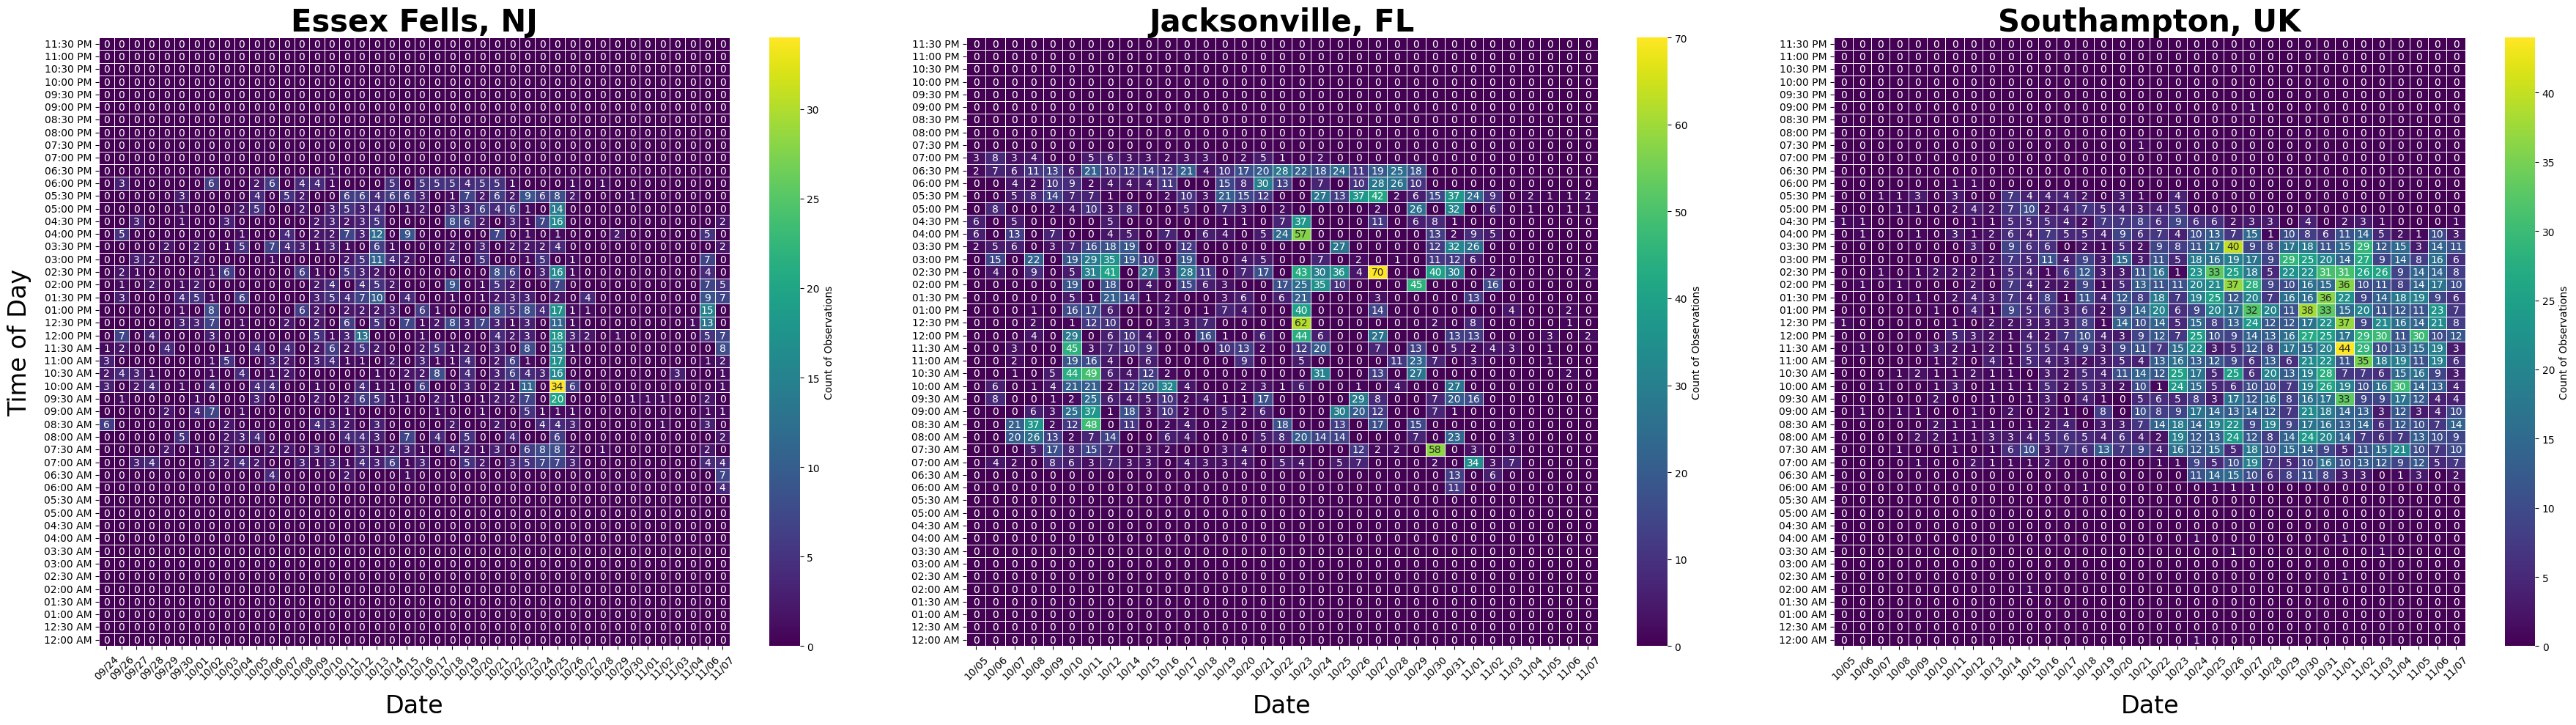

Saved: Heatmap: Date vs Time of Day as a Count of Observations -> heatmap_counts


'heatmap_counts'

In [43]:
# Plot heatmaps for each location
fig = plot_heatmap_counts_subplots(location_data)

# Save heatmap plots for dashboard
save_plot_for_dashboard(
    fig, 
    'heatmap_counts', 
    'Heatmap: Date vs Time of Day as a Count of Observations',
    'Heatmap showing bird activity patterns across dates and times of day for each location'
)

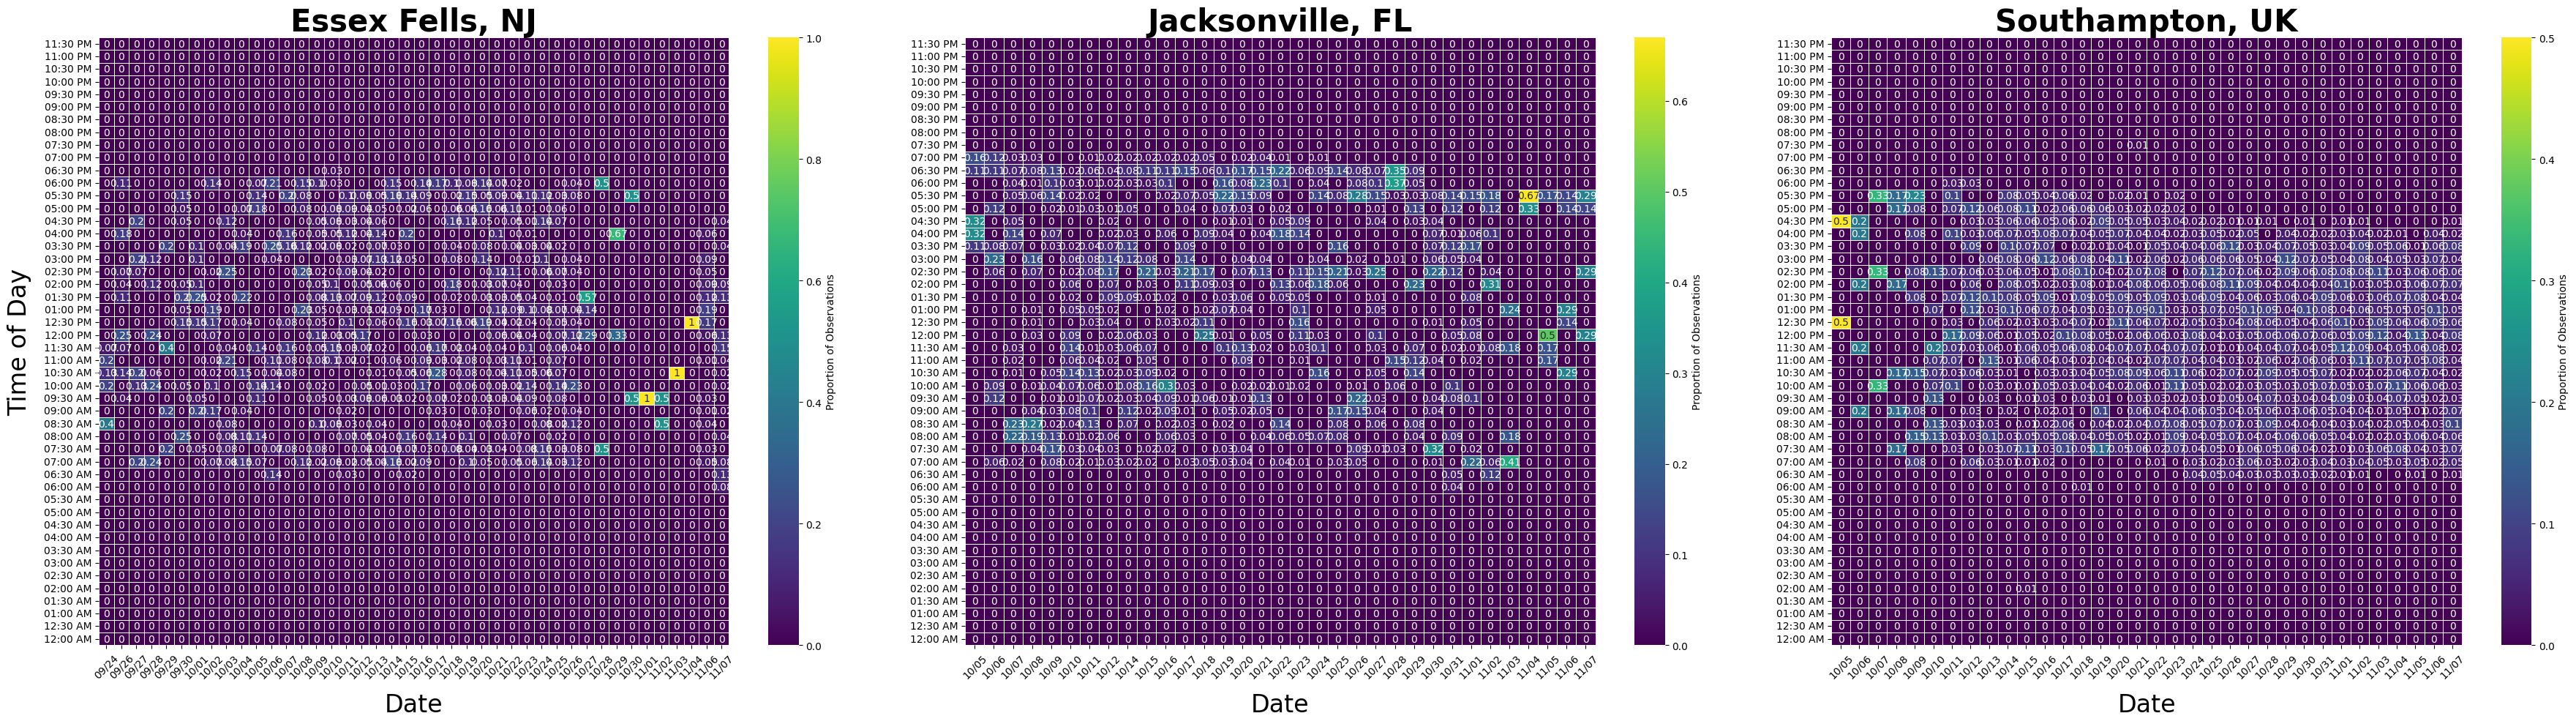

Saved: Heatmap: Date vs Time of Day as a Proportion of Observations -> heatmap_proportions


'heatmap_proportions'

In [44]:
# Plot proportions heatmaps for each location
fig = plot_heatmap_proportions_subplots(location_data)

# Save proportions heatmap for dashboard
save_plot_for_dashboard(
    fig, 
    'heatmap_proportions', 
    'Heatmap: Date vs Time of Day as a Proportion of Observations',
    'Heatmap showing proportional bird activity patterns across dates and times of day for each location'
)

# Bout Analyses

In [45]:
# Add inter-visit interval (IVI) data 
raw_data_ivi = pd.DataFrame()
for location in raw_data['source_sheet'].unique():
    location_data = raw_data[raw_data['source_sheet'] == location].copy()
    
    # Convert to datetime
    location_data['Date'] = pd.to_datetime(location_data['Date'])
    location_data['Time'] = pd.to_datetime(location_data['Time'])
    
    # Combine date and time, handling NaT values
    location_data['date_time'] = location_data['Date'] + pd.to_timedelta(location_data['Time'].dt.hour, unit='h') + pd.to_timedelta(location_data['Time'].dt.minute, unit='m') + pd.to_timedelta(location_data['Time'].dt.second, unit='s')
    location_data = location_data.sort_values(by='date_time', ascending=True).reset_index(drop=True)
    
    # Calculate IVI (inter-visit interval) in minutes
    location_data['IVI (mins)'] = location_data['date_time'].diff().dt.total_seconds() / 60
    
    raw_data_ivi = pd.concat([raw_data_ivi, location_data])

raw_data_ivi = raw_data_ivi.dropna(subset=['IVI (mins)']).reset_index(drop=True)

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/11940605.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  location_data['Time'] = pd.to_datetime(location_data['Time'])
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/11940605.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  location_data['Time'] = pd.to_datetime(location_data['Time'])
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/11940605.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  location_data['Time'] = pd.to_datetime(location_data['Time'])


In [46]:
# --- normalize in place ---
raw_data_ivi['source_sheet'] = raw_data_ivi['source_sheet'].astype(str).str.strip()
raw_data_ivi['Date'] = pd.to_datetime(raw_data_ivi['Date'], errors='coerce')

phase_changes['LocationOfChange'] = phase_changes['LocationOfChange'].astype(str).str.strip()
phase_changes['DateChangeStarted'] = pd.to_datetime(phase_changes['DateChangeStarted'], errors='coerce')

BASELINE = 'Seed'

def to_condition(txt: str) -> str:
    t = str(txt).lower()
    if 'seed' in t and 'extinct' not in t:
        return 'Seed'
    if 'extinct' in t or 'extinction' in t or 'no seed' in t:
        return 'No Seed'
    return 'No Seed'

phase_changes['Condition'] = phase_changes['DescriptionOfChange'].map(to_condition)

# Will hold the result keyed by the existing index of raw_data_ivi
seed_status = pd.Series(index=raw_data_ivi.index, dtype=object)

for loc, sub in raw_data_ivi.groupby('source_sheet'):
    loc_idx = sub.index
    dates = sub['Date'].to_numpy(dtype='datetime64[ns]')

    pc = (phase_changes
          .loc[phase_changes['LocationOfChange'].eq(loc),
               ['DateChangeStarted','Condition']]
          .sort_values('DateChangeStarted'))

    if pc.empty:
        seed_status.loc[loc_idx] = BASELINE
        continue

    change_dates = pc['DateChangeStarted'].to_numpy(dtype='datetime64[ns]')
    labels = pc['Condition'].to_numpy(object)

    # most recent change at or before each date (ties -> apply new change now)
    ix = np.searchsorted(change_dates, dates, side='right') - 1

    loc_status = np.where(ix >= 0, labels[np.clip(ix, 0, len(labels)-1)], BASELINE)
    seed_status.loc[loc_idx] = loc_status

# write back to the original df
raw_data_ivi['SeedStatus'] = seed_status

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/911483404.py:7: RuntimeWarning: overflow encountered in exp
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/911483404.py:7: RuntimeWarning: invalid value encountered in log
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/911483404.py:7: RuntimeWarning: overflow encountered in exp
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/911483404.py:7: RuntimeWarning: overflow encountered in exp
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)


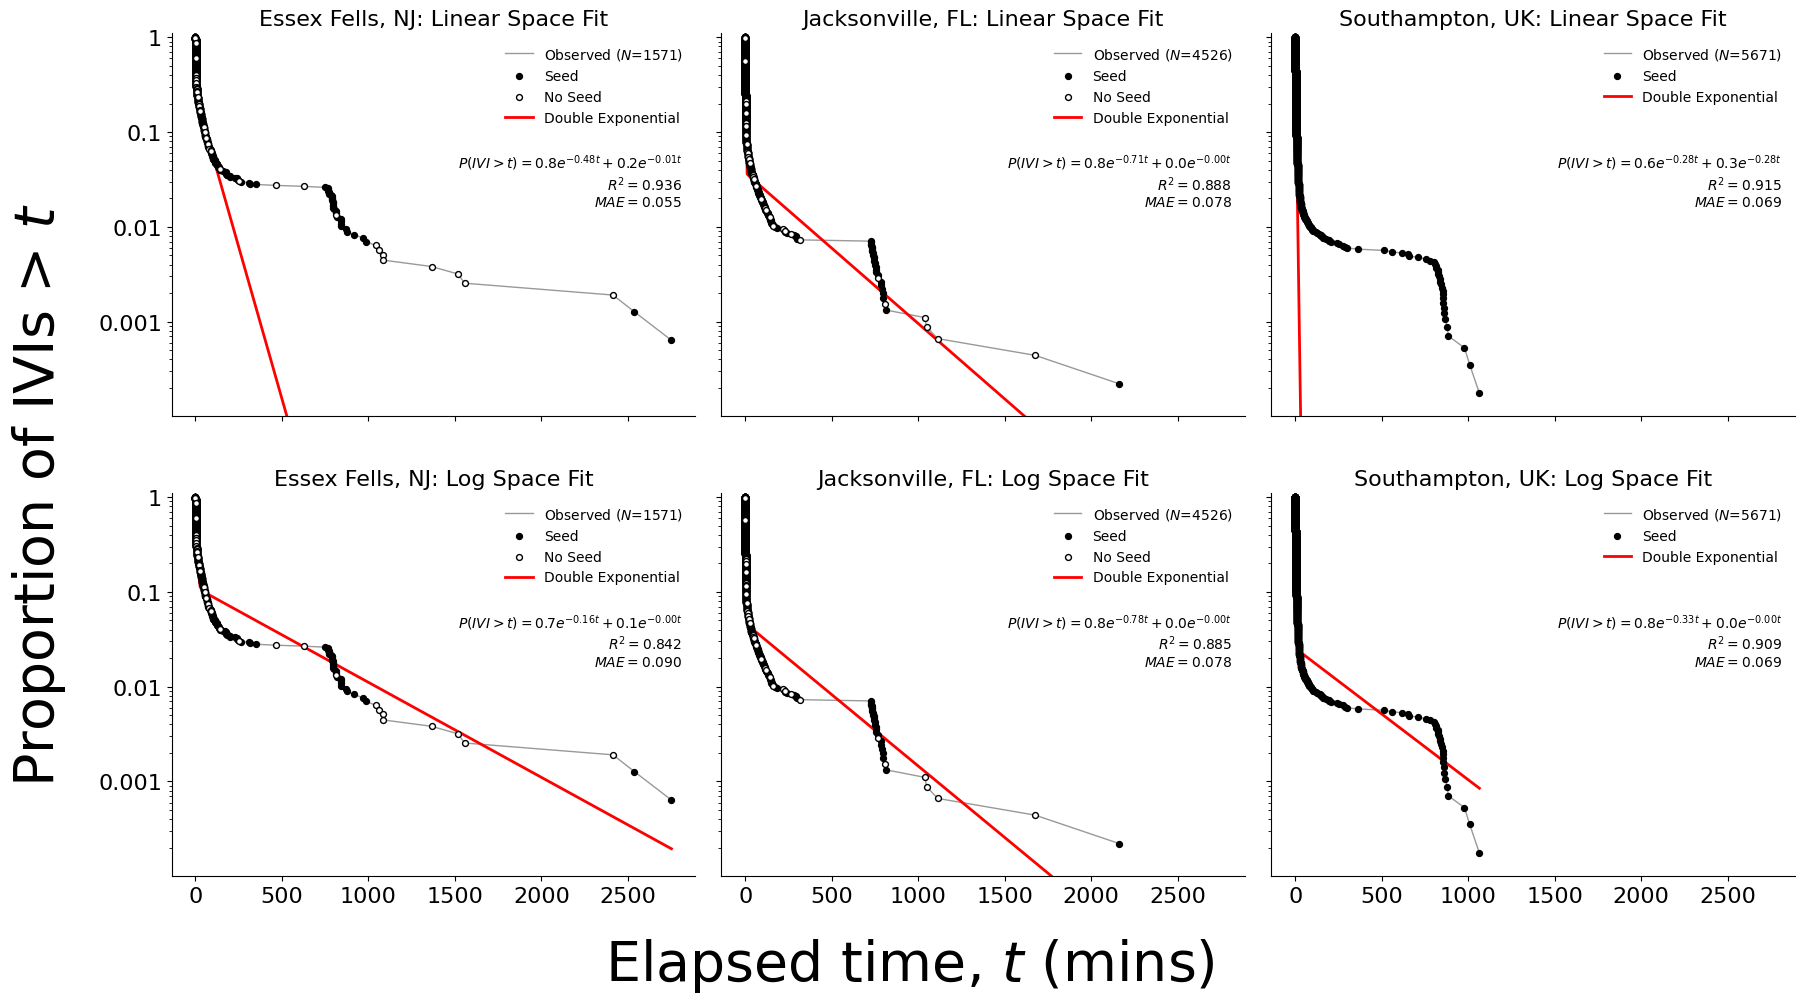

In [47]:
def double_exponential_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential survivor function"""
    return A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t)

def double_exponential_log_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential in log-space"""
    return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)

# status → color (match what you want in the legend)
STATUS_PALETTE = [
    ('Seed', 'black'),
    ('No Seed', 'white'),
    ('Unknown', 'gray'),
]

# Get unique locations
locations = sorted(raw_data_ivi['source_sheet'].unique())
n_locations = len(locations)

# Create 2xN subplot layout (2 rows for fit types)
fig, axes = plt.subplots(2, n_locations, figsize=(6*n_locations, 10), sharey=True, sharex=True)
if n_locations == 1:
    axes = axes.reshape(2, 1)

def _dedupe_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    h2, l2 = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l); h2.append(h); l2.append(l)
    ax.legend(h2, l2, loc='lower left', fontsize=10, frameon=False)

# Process each location
for col, location in enumerate(locations):
    # Get data for this location
    location_data = raw_data_ivi[raw_data_ivi['source_sheet'] == location]
    loc_df = location_data[['IVI (mins)', 'SeedStatus']].dropna().copy()
    if loc_df.empty:
        continue

    loc_df['SeedStatus'] = loc_df['SeedStatus'].fillna('Unknown')
    loc_df = loc_df.sort_values('IVI (mins)')

    # Survivor function inputs
    x = loc_df['IVI (mins)'].to_numpy()
    n = len(x)
    y = np.arange(n, 0, -1) / n
    status = loc_df['SeedStatus'].to_numpy()

    # Fitting
    time_points = x
    survivor = y
    initial_guess = [0.4, 0.5, 0.6, 0.02]

    try:
        # Linear-space fit
        popt_linear, pcov_linear = curve_fit(
            double_exponential_survivor, time_points, survivor,
            p0=initial_guess, maxfev=10000
        )
        y_pred_linear = double_exponential_survivor(time_points, *popt_linear)
        r_squared_linear = 1 - (np.sum((survivor - y_pred_linear) ** 2) /
                                np.sum((survivor - np.mean(survivor)) ** 2))
        mae_linear = float(np.mean(np.abs(survivor - y_pred_linear)))

        # Log-space fit
        log_survivor = np.log(survivor + 1e-10)
        popt_log, pcov_log = curve_fit(
            double_exponential_log_survivor, time_points, log_survivor,
            p0=initial_guess, maxfev=10000
        )
        y_pred_log = double_exponential_log_survivor(time_points, *popt_log)
        y_pred_log_linear = np.exp(y_pred_log)
        r_squared_log = 1 - (np.sum((survivor - y_pred_log_linear) ** 2) /
                             np.sum((survivor - np.mean(survivor)) ** 2))
        mae_log = float(np.mean(np.abs(survivor - y_pred_log_linear)))

        # Smooth fit curves
        t_smooth = np.linspace(0, x.max(), 200)
        y_smooth_linear = double_exponential_survivor(t_smooth, *popt_linear)
        y_smooth_log_linear = np.exp(double_exponential_log_survivor(t_smooth, *popt_log))

        text_x = 0.975
        text_y = 0.65

        # ---------- TOP: linear-space fit ----------
        ax1 = axes[0, col]
        ax1.semilogy(x, y, '-', linewidth=1, color='0.6', label=f'Observed ($N$={n})')

        # one scatter per SeedStatus (avoids long list for c=)
        for lbl, colr in STATUS_PALETTE:
            m = (status == lbl)
            if m.any():
                ax1.scatter(x[m], y[m], s=18, color=colr, edgecolor='black', zorder=3, label=lbl)

        ax1.semilogy(t_smooth, y_smooth_linear, '-', linewidth=2, color='red', label='Double Exponential')
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax1.set_yticks([0.001, 0.01, 0.1, 1])
        ax1.set_yticklabels(['0.001', '0.01', '0.1', '1'], fontsize=16)
        ax1.tick_params(axis='x', labelsize=16)
        ax1.set_ylim(0.0001, 1.1)
        sns.despine(top=True, right=True, ax=ax1)

        eq1 = (f'$P(IVI>t) = {popt_linear[0]:.1f}e^{{-{popt_linear[1]:.2f}t}}'
               f' + {popt_linear[2]:.1f}e^{{-{popt_linear[3]:.2f}t}}$')
        ax1.text(text_x, text_y, eq1, transform=ax1.transAxes,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
                 fontsize=10, ha='right')
        ax1.text(text_x, text_y-0.1, f'$R^2 = {r_squared_linear:.3f}$\n$MAE = {mae_linear:.3f}$',
                 transform=ax1.transAxes,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
                 fontsize=10, ha='right')
        ax1.set_title(f"{location}: Linear Space Fit", fontsize=16)
        _dedupe_legend(ax1)
        ax1.legend(loc='best', fontsize=10, frameon=False)

        # ---------- BOTTOM: log-space fit (shown in linear scale) ----------
        ax2 = axes[1, col]
        ax2.semilogy(x, y, '-', linewidth=1, color='0.6', label=f'Observed ($N$={n})')
        for lbl, colr in STATUS_PALETTE:
            m = (status == lbl)
            if m.any():
                ax2.scatter(x[m], y[m], s=18, color=colr, edgecolor='black', zorder=3, label=lbl)

        ax2.semilogy(t_smooth, y_smooth_log_linear, '-', linewidth=2, color='red', label='Double Exponential')
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax2.set_yticks([0.001, 0.01, 0.1, 1])
        ax2.set_yticklabels(['0.001', '0.01', '0.1', '1'], fontsize=16)
        ax2.tick_params(axis='x', labelsize=16)
        ax2.set_ylim(0.0001, 1.1)
        sns.despine(top=True, right=True, ax=ax2)

        eq2 = (f'$P(IVI>t) = {popt_log[0]:.1f}e^{{-{popt_log[1]:.2f}t}}'
               f' + {popt_log[2]:.1f}e^{{-{popt_log[3]:.2f}t}}$')
        ax2.text(text_x, text_y, eq2, transform=ax2.transAxes,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
                 fontsize=10, ha='right')
        ax2.text(text_x, text_y-0.1, f'$R^2 = {r_squared_log:.3f}$\n$MAE = {mae_log:.3f}$',
                 transform=ax2.transAxes,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
                 fontsize=10, ha='right')
        ax2.set_title(f"{location}: Log Space Fit", fontsize=16)
        _dedupe_legend(ax2)
        ax2.legend(loc='best', fontsize=10, frameon=False)

    except Exception as e:
        print(f"Error fitting data for {location}: {e}")
        axes[0, col].text(0.5, 0.5, f"Error fitting data\nfor {location}",
                          transform=axes[0, col].transAxes, ha='center', va='center')
        axes[1, col].text(0.5, 0.5, f"Error fitting data\nfor {location}",
                          transform=axes[1, col].transAxes, ha='center', va='center')

# Add single super labels
fig.supxlabel('Elapsed time, $t$ (mins)', fontsize=40, y=-0.0)
fig.supylabel('Proportion of IVIs > $t$', fontsize=40, x=0.0)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.05)
plt.show()

In [48]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'all_birds_bout_analysis', 
    'All Birds: Bout Analysis',
    'Analysis of bout durations for all birds'
)

Saved: All Birds: Bout Analysis -> all_birds_bout_analysis


'all_birds_bout_analysis'

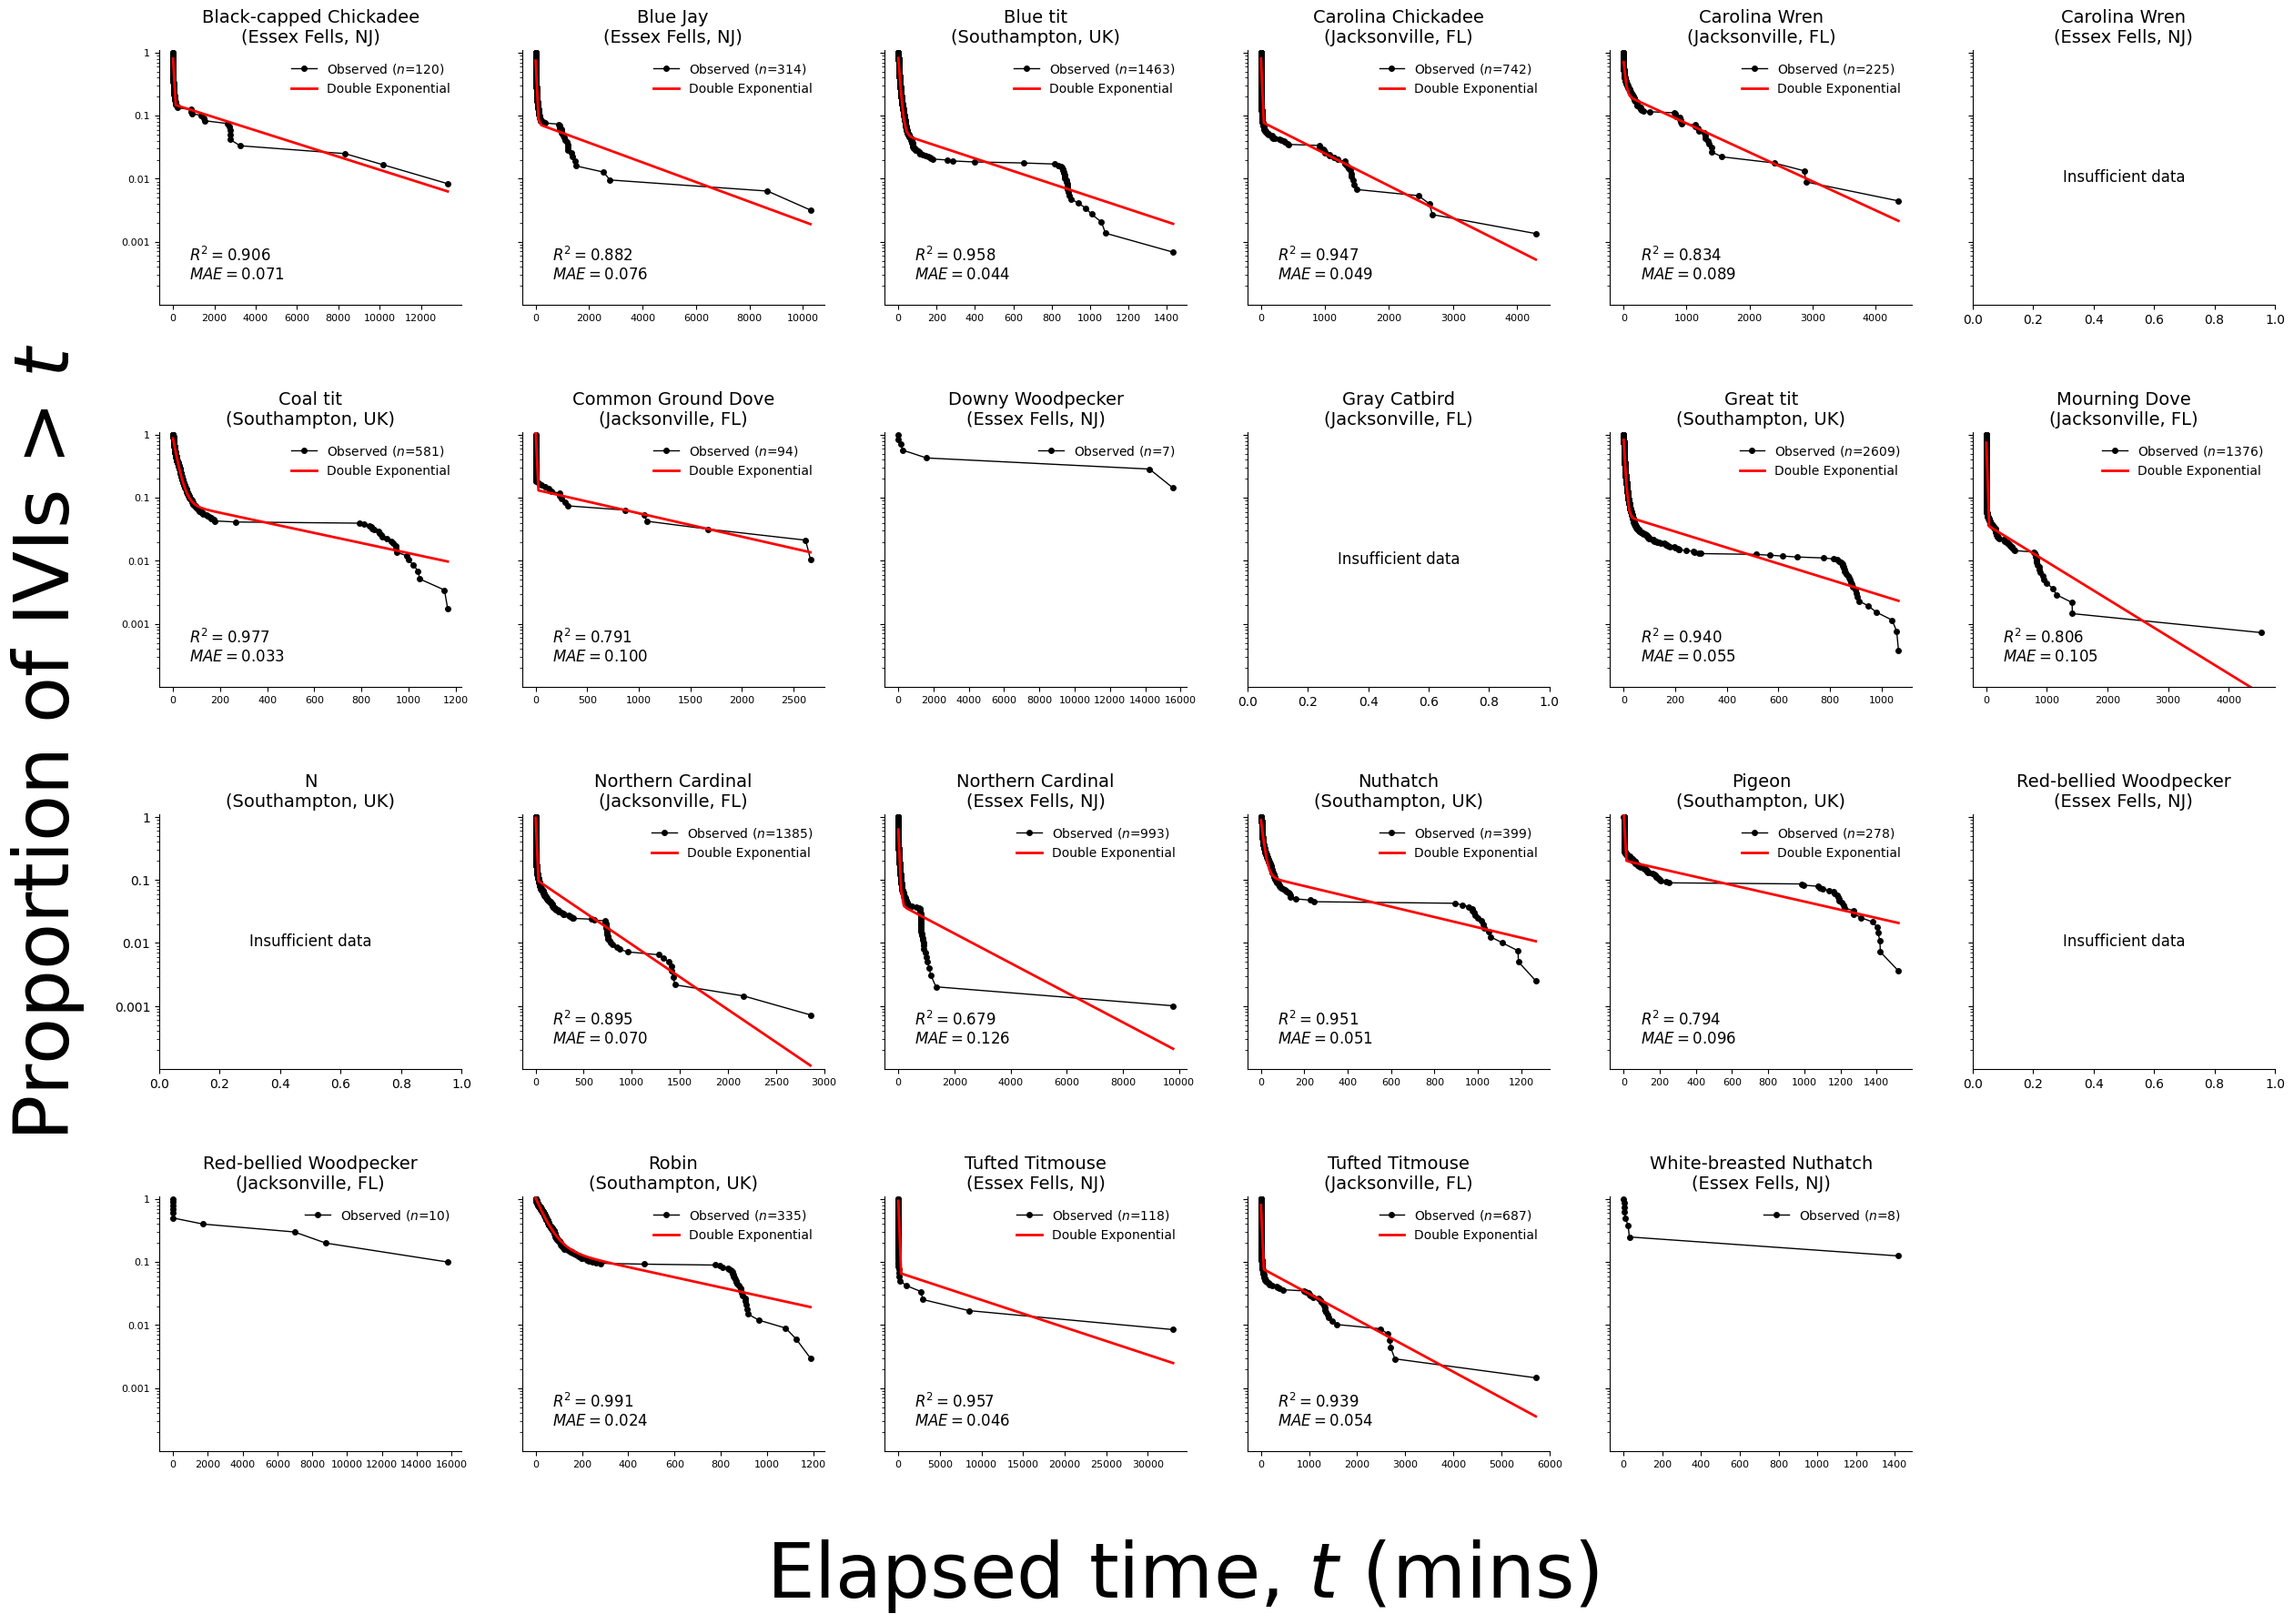

In [49]:
def double_exponential_log_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential in log-space"""
    return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)

def fit_bout_model_for_bird(data, bird_species):
    bird_data = data[data['Bird'] == bird_species]['IVI (mins)'].dropna()
    
    if len(bird_data) < 10:
        return None, None, None, None
    
    sorted_ivi = np.sort(bird_data)
    n = len(sorted_ivi)
    survivor = np.arange(n, 0, -1) / n
    time_points = sorted_ivi
    
    # Work in log-space
    log_survivor = np.log(survivor + 1e-10)
    
    # More flexible initial guess based on data characteristics
    mean_ivi = bird_data.mean()
    std_ivi = bird_data.std()
    
    # Try multiple initial guesses
    initial_guesses = [
        [0.8, 1.0/mean_ivi, 0.2, 0.01/mean_ivi],  # Original
        [0.6, 0.5/mean_ivi, 0.4, 0.05/mean_ivi],   # Alternative 1
        [0.9, 2.0/mean_ivi, 0.1, 0.001/mean_ivi],   # Alternative 2
        [0.5, 0.1/mean_ivi, 0.5, 0.1/mean_ivi],     # Alternative 3
    ]
    
    # Much more relaxed bounds
    bounds = ([0.01, 0.001, 0.01, 0.0001], [1.0, 50, 1.0, 10])
    
    for initial_guess in initial_guesses:
        try:
            # Fit in log-space
            popt, pcov = curve_fit(double_exponential_log_survivor, time_points, log_survivor, 
                                 p0=initial_guess, bounds=bounds, maxfev=20000)
            
            # Convert back to linear space for evaluation
            y_pred_log = double_exponential_log_survivor(time_points, *popt)
            y_pred = np.exp(y_pred_log)
            
            # Calculate metrics in linear space
            r_squared = 1 - (np.sum((survivor - y_pred) ** 2) / np.sum((survivor - np.mean(survivor)) ** 2))
            mae = np.mean(np.abs(survivor - y_pred))
            
            # Only return if we get a reasonable fit
            if r_squared > 0.5:  # Minimum R² threshold
                return popt, pcov, r_squared, mae
                
        except:
            continue
    
    return None, None, None, None

# First, calculate IVIs for each bird separately
raw_data_ivi = pd.DataFrame()

# Get unique bird-location combinations
raw_data = raw_data.dropna(subset=['Bird'])
# raw_data = raw_data[raw_data['Bird'] != 'Gray Catbird']
bird_location_pairs = raw_data[['Bird', 'source_sheet']].drop_duplicates()

for _, row in bird_location_pairs.iterrows():
    bird = row['Bird']
    location = row['source_sheet']
    
    # Get data for this specific bird-location combination
    bird_data = raw_data[(raw_data['Bird'] == bird) & (raw_data['source_sheet'] == location)].copy()
    
    if len(bird_data) < 5:  # Skip if insufficient data
        continue
    
    # Convert to datetime with explicit format to avoid warnings
    bird_data['Date'] = pd.to_datetime(bird_data['Date'], format='%Y-%m-%d')
    bird_data['Time'] = pd.to_datetime(bird_data['Time'], format='%H:%M:%S')
    
    # Combine date and time, handling NaT values
    bird_data['date_time'] = bird_data['Date'] + pd.to_timedelta(bird_data['Time'].dt.hour, unit='h') + pd.to_timedelta(bird_data['Time'].dt.minute, unit='m') + pd.to_timedelta(bird_data['Time'].dt.second, unit='s')
    bird_data = bird_data.sort_values(by='date_time', ascending=True).reset_index(drop=True)
    
    # Calculate IVI (inter-visit interval) in minutes
    bird_data['IVI (mins)'] = bird_data['date_time'].diff().dt.total_seconds() / 60
    
    raw_data_ivi = pd.concat([raw_data_ivi, bird_data])

# Remove rows with NaN IVI values
raw_data_ivi = raw_data_ivi.dropna(subset=['IVI (mins)'])

# Sort by bird name
bird_location_pairs = bird_location_pairs.sort_values('Bird')

# Calculate number of subplots needed for square-ish layout
n_species = len(bird_location_pairs)
n_cols = 6
n_rows = int(np.ceil(n_species / n_cols))  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), sharey=True)
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Plot for each bird species
for i, (_, row) in enumerate(bird_location_pairs.iterrows()):
    bird = row['Bird']
    location = row['source_sheet']
    
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axes[row_idx, col_idx]
    
    # Get data for this bird-location combination
    bird_data = raw_data_ivi[(raw_data_ivi['Bird'] == bird) & (raw_data_ivi['source_sheet'] == location)]['IVI (mins)'].dropna()
    
    if len(bird_data) < 5:
        ax.text(0.5, 0.5, f'Insufficient data', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{bird}\n({location})', fontsize=14)
        sns.despine(top=True, right=True)
        continue
    
    # Sort the data
    sorted_ivi = np.sort(bird_data)
    
    # Calculate survivor function
    n = len(sorted_ivi)
    survivor = np.arange(n, 0, -1) / n
    
    # Create time points for fitting
    time_points = sorted_ivi
    
    # Fit the model
    popt, pcov, r_squared, mae = fit_bout_model_for_bird(raw_data_ivi[(raw_data_ivi['Bird'] == bird) & (raw_data_ivi['source_sheet'] == location)], bird)
    
    if popt is not None:
        # Plot observed data
        ax.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
                   label=f'Observed ($n$={len(bird_data)})')
        
        # Plot fitted model - transform back to linear space
        t_smooth = np.linspace(0, bird_data.max(), 100)
        y_smooth_log = double_exponential_log_survivor(t_smooth, *popt)
        y_smooth = np.exp(y_smooth_log)
        ax.semilogy(t_smooth, y_smooth, 'r-', linewidth=2, 
                   label=f'Double Exponential')
        
        # Plot individual components - transform back to linear space
        within_bout_log = np.log(popt[0] * np.exp(-popt[1] * t_smooth) + 1e-10)
        between_bout_log = np.log(popt[2] * np.exp(-popt[3] * t_smooth) + 1e-10)
        within_bout = np.exp(within_bout_log)
        between_bout = np.exp(between_bout_log)
        
        text_x = 0.1
        
        # Add metrics text
        metrics_text = f'$R^2 = {r_squared:.3f}$\n$MAE = {mae:.3f}$'
        ax.text(text_x, 0.1, metrics_text, transform=ax.transAxes, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
               fontsize=12)
    else:
        # Plot just the observed data if model fitting failed
        ax.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
                   label=f'Observed ($n$={len(bird_data)})')
    
    # Remove individual labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set formatting
    ax.legend(loc='best', fontsize=10, frameon=False)
    ax.set_yticks(ticks=[0.001, 0.01, 0.1, 1], 
                  labels=['0.001', '0.01', '0.1', '1'], 
                  fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_ylim(0.0001, 1.1)
    ax.set_title(f'{bird}\n({location})', fontsize=14)
    
    sns.despine(top=True, right=True)

# Hide empty subplots
for i in range(n_species, n_rows * n_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols
    axes[row_idx, col_idx].set_visible(False)

# Add single super labels
fig.supxlabel('Elapsed time, $t$ (mins)', fontsize=60, y=0.02)
fig.supylabel('Proportion of IVIs > $t$', fontsize=60, x=0.07)

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

In [50]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'individual_species_bout_analysis', 
    'Bird Species: Bout Analysis (log space)',
    'Analysis of bout durations for individual bird species'
)


Saved: Bird Species: Bout Analysis (log space) -> individual_species_bout_analysis


'individual_species_bout_analysis'

# Add Migration Information

In [51]:
# bird_cast = pd.read_csv(BIRDCAST_CSV)
bird_cast= pd.read_parquet(BIRDCAST_PARQUET)
bird_cast_trim = bird_cast[['migration_start_utc', 'region_name', 'total_birds']].copy()
bird_cast_trim['total_birds'] = bird_cast_trim['total_birds'].astype(float)  # Convert to float first
bird_cast_trim['migration_start_utc'] = pd.to_datetime(bird_cast_trim['migration_start_utc']).dt.strftime('%Y-%m-%d')
bird_cast_trim = bird_cast[bird_cast['migration_start_utc'] > '2025-10-02'].copy()
bird_cast_trim['total_birds'] = bird_cast_trim['total_birds'] / 1_000_000  # Now this will work without warning
bird_cast_trim = bird_cast_trim.sort_values(by='migration_start_utc', ascending=True).reset_index(drop=True)

# Make sure regions align
bird_cast_region_dict = {
    'Duval County, Florida': 'Jacksonville, FL',
    'Essex County, New Jersey': 'Essex Fells, NJ',
    'Boulder County, Colorado': 'Boulder, CO',
    'Lee County, Alabama': 'Lee County, AL',
    'Contra Costa County, California': 'Contra Costa County, CA'
}

bird_cast_trim['region_name'] = bird_cast_trim['region_name'].map(bird_cast_region_dict)

In [52]:
# Convert both date columns to string format YYYY-MM-DD
all_birds_feeder = daily_summs.groupby(['Date', 'source_sheet']).agg({'Feeder Visits': 'sum'}).reset_index()
all_birds_feeder['Date_str'] = pd.to_datetime(all_birds_feeder['Date']).dt.strftime('%Y-%m-%d')
bird_cast_trim['migration_date_str'] = pd.to_datetime(bird_cast_trim['migration_start_utc']).dt.strftime('%Y-%m-%d')

# Now merge using the string dates
bird_cast_totals = bird_cast_trim[['migration_date_str', 'region_name', 'total_birds']]

merged_data = all_birds_feeder.merge(
    bird_cast_totals,
    left_on=['Date_str', 'source_sheet'],
    right_on=['migration_date_str', 'region_name'],
    how='left'
)

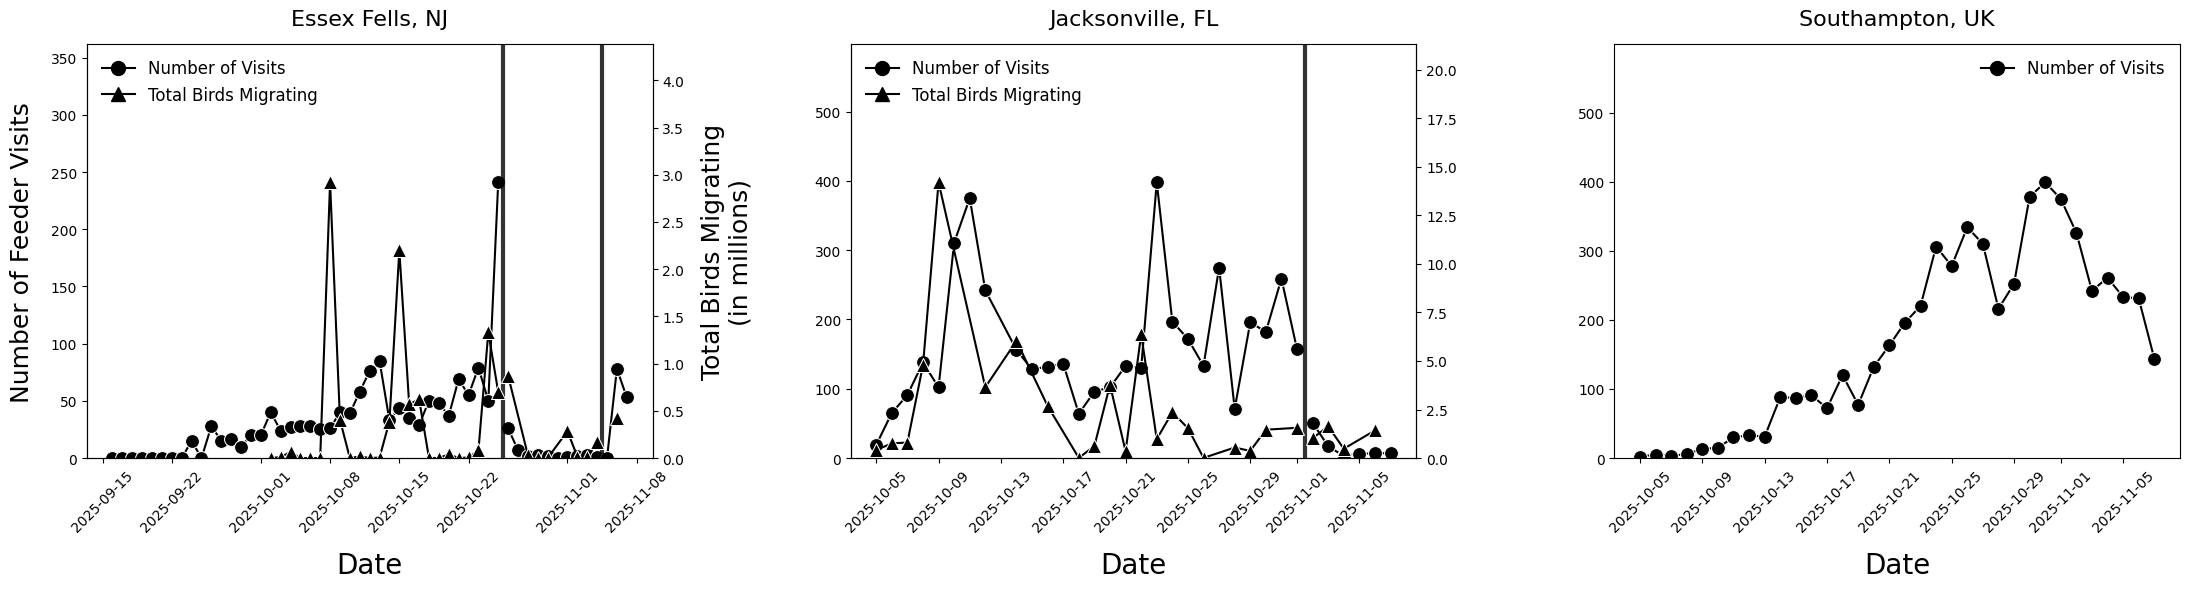

In [ ]:
# --- Prep: ensure datetime axis ---
merged_data['Date_dt'] = pd.to_datetime(merged_data['Date_str'])
phase_changes['DateChangeStarted'] = pd.to_datetime(phase_changes['DateChangeStarted'])

# --- Helper: draw the phase-change line between LAST<change and FIRST>=change,
#             and place the label at the top of the subplot, just to the RIGHT of the line. ---
def draw_phase(ax, df_with_dt, change_dt, text):
    dates = np.sort(df_with_dt['Date'].unique())
    if dates.size == 0:
        return

    # Find the last point strictly before the change and the first point at/after the change
    left_candidates = dates[dates < change_dt]
    right_candidates = dates[dates >= change_dt]

    if left_candidates.size > 0 and right_candidates.size > 0:
        left, right = left_candidates[-1], right_candidates[0]
    else:
        # Fallbacks if change date is outside data range or only one point exists
        if dates.size >= 2:
            left, right = dates[-2], dates[-1]
        else:
            left = right = dates[0]

    # Midpoint between left (end of old condition) and right (first in new condition)
    half = left + (right - left) / 2

    # Vertical line at midpoint
    ax.axvline(half, color='black', linestyle='-', linewidth=3, alpha=0.8)

    # Condition label: top of axes, just to the RIGHT of the line
    # (x in data coords, y in axes coords; slight +2pt x offset so it doesn't touch the line)
    ax.annotate(
        text, xy=(half, 0.98), xycoords=(ax.get_xaxis_transform()),
        xytext=(2, 0), textcoords='offset points',
        rotation=90, ha='left', va='top', fontsize=10
    )

# --- Regions to plot ---
regions = ['Essex Fells, NJ', 'Jacksonville, FL']

# --- Figure / axes ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# --- Plot each region with migration on a secondary axis ---
for i, region in enumerate(regions):
    ax1 = axes[i]
    region_data = (
        merged_data[merged_data['source_sheet'] == region]
        .copy()
        .sort_values('Date_dt')
    )

    location_phase_changes = phase_changes[phase_changes['LocationOfChange'] == region].copy()
    
    # Get all phase change dates sorted chronologically
    phase_change_dates = []
    if not location_phase_changes.empty:
        phase_change_dates = sorted([
            pd.to_datetime(date) 
            for date in location_phase_changes['DateChangeStarted'].unique()
        ])

    # Split data at all phase changes for visits (primary y)
    if len(phase_change_dates) > 0:
        # Create segments: before first change, between changes, after last change
        visit_segments = []
        
        # First segment: before first phase change
        first_segment = region_data[region_data['Date_dt'] < phase_change_dates[0]]
        if not first_segment.empty:
            visit_segments.append(first_segment)
        
        # Middle segments: between consecutive phase changes
        for j in range(len(phase_change_dates) - 1):
            segment = region_data[
                (region_data['Date_dt'] >= phase_change_dates[j]) & 
                (region_data['Date_dt'] < phase_change_dates[j + 1])
            ]
            if not segment.empty:
                visit_segments.append(segment)
        
        # Last segment: after last phase change
        last_segment = region_data[region_data['Date_dt'] >= phase_change_dates[-1]]
        if not last_segment.empty:
            visit_segments.append(last_segment)
        
        # Plot each segment separately
        for seg_idx, segment in enumerate(visit_segments):
            if not segment.empty:
                sns.lineplot(x='Date_dt', y='Feeder Visits', data=segment, ax=ax1,
                             marker='o', markersize=10, color='black', 
                             label='Number of Visits' if seg_idx == 0 else '', legend=False)
    else:
        # No phase change, plot normally
        sns.lineplot(x='Date_dt', y='Feeder Visits', data=region_data, ax=ax1,
                     marker='o', markersize=10, color='black', label='Number of Visits', legend=False)

    # Migration (secondary y)
    ax2 = ax1.twinx()
    migration_data = region_data.dropna(subset=['total_birds'])
    if not migration_data.empty:
        # Split migration data at all phase changes
        if len(phase_change_dates) > 0:
            migration_segments = []
            
            # First segment: before first phase change
            first_mig_segment = migration_data[migration_data['Date_dt'] < phase_change_dates[0]]
            if not first_mig_segment.empty:
                migration_segments.append(first_mig_segment)
            
            # Middle segments: between consecutive phase changes
            for j in range(len(phase_change_dates) - 1):
                mig_segment = migration_data[
                    (migration_data['Date_dt'] >= phase_change_dates[j]) & 
                    (migration_data['Date_dt'] < phase_change_dates[j + 1])
                ]
                if not mig_segment.empty:
                    migration_segments.append(mig_segment)
            
            # Last segment: after last phase change
            last_mig_segment = migration_data[migration_data['Date_dt'] >= phase_change_dates[-1]]
            if not last_mig_segment.empty:
                migration_segments.append(last_mig_segment)
            
            # Plot each segment separately
            for mig_seg_idx, mig_segment in enumerate(migration_segments):
                if not mig_segment.empty:
                    sns.lineplot(x='Date_dt', y='total_birds', data=mig_segment, ax=ax2,
                                 marker='^', markersize=10, color='black', 
                                 label='Total Birds Migrating' if mig_seg_idx == 0 else '', legend=False)
        else:
            # No phase change, plot normally
            sns.lineplot(x='Date_dt', y='total_birds', data=migration_data, ax=ax2,
                         marker='^', markersize=10, color='black', label='Total Birds Migrating', legend=False)

        ax2.set_ylabel('Total Birds Migrating\n(in millions)', fontsize=18, labelpad=12)

    # Draw all phase-change markers for this location
    for _, phase_row in location_phase_changes.iterrows():
        change_date = pd.to_datetime(phase_row['DateChangeStarted'])
        description = phase_row['DescriptionOfChange']
        draw_phase(ax1, location_data, change_date, description)

    # Labels, limits, legend
    vis_max = np.nanmax(region_data['Feeder Visits'].values) if len(region_data) else 1
    ax1.set_ylim(0, vis_max * 1.5 if np.isfinite(vis_max) else 1)
    if not migration_data.empty:
        mig_max = np.nanmax(migration_data['total_birds'].values)
        ax2.set_ylim(0, mig_max * 1.5 if np.isfinite(mig_max) else 1)

    if i == 0:
        ax1.set_ylabel('Number of Feeder Visits', fontsize=18, labelpad=12)
    else:
        ax1.set_ylabel('')
        ax2.set_ylabel('')

    ax1.set_xlabel('Date', fontsize=20, labelpad=12)
    ax1.set_title(region, fontsize=16, pad=14)
    ax1.tick_params(axis='x', rotation=45)

    legend_elements = [
        Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=10, label='Number of Visits'),
        Line2D([0], [0], color='black', marker='^', linestyle='-', markersize=10, label='Total Birds Migrating'),
    ]
    ax1.legend(handles=legend_elements, loc="best", frameon=False, fontsize=12)

    sns.despine(top=True, right=False, left=False, ax=ax1)

# --- Southampton (visits only) ---
ax_southampton = axes[2]
southampton_data = (
    merged_data[merged_data['source_sheet'] == 'Southampton, UK']
    .copy()
    .sort_values('Date_dt')
)

# Phase changes for Southampton
location_phase_changes_southampton = phase_changes[phase_changes['LocationOfChange'] == 'Southampton, UK'].copy()

# Get all phase change dates sorted chronologically
phase_change_dates_south = []
if not location_phase_changes_southampton.empty:
    phase_change_dates_south = sorted([
        pd.to_datetime(date) 
        for date in location_phase_changes_southampton['DateChangeStarted'].unique()
    ])

# Split visits for Southampton at all phase changes
if len(phase_change_dates_south) > 0:
    # Create segments: before first change, between changes, after last change
    southampton_segments = []
    
    # First segment: before first phase change
    first_segment = southampton_data[southampton_data['Date_dt'] < phase_change_dates_south[0]]
    if not first_segment.empty:
        southampton_segments.append(first_segment)
    
    # Middle segments: between consecutive phase changes
    for j in range(len(phase_change_dates_south) - 1):
        segment = southampton_data[
            (southampton_data['Date_dt'] >= phase_change_dates_south[j]) & 
            (southampton_data['Date_dt'] < phase_change_dates_south[j + 1])
        ]
        if not segment.empty:
            southampton_segments.append(segment)
    
    # Last segment: after last phase change
    last_segment = southampton_data[southampton_data['Date_dt'] >= phase_change_dates_south[-1]]
    if not last_segment.empty:
        southampton_segments.append(last_segment)
    
    # Plot each segment separately
    for seg_idx, segment in enumerate(southampton_segments):
        if not segment.empty:
            sns.lineplot(x='Date_dt', y='Feeder Visits', data=segment, ax=ax_southampton,
                         marker='o', markersize=10, color='black', 
                         label='Number of Visits' if seg_idx == 0 else '', legend=False)
else:
    # No phase change, plot normally
    sns.lineplot(x='Date_dt', y='Feeder Visits', data=southampton_data, ax=ax_southampton,
                 marker='o', markersize=10, color='black', label='Number of Visits', legend=False)

# Draw phase lines / labels
for _, row in location_phase_changes_southampton.iterrows():
    change_date = pd.to_datetime(row['DateChangeStarted'])
    draw_phase(ax_southampton, southampton_data, change_date, row['DescriptionOfChange'])

# Labels, limits, legend
vis_max_s = np.nanmax(southampton_data['Feeder Visits'].values) if len(southampton_data) else 1
ax_southampton.set_ylim(0, vis_max_s * 1.5 if np.isfinite(vis_max_s) else 1)

ax_southampton.set_ylabel('')
ax_southampton.set_xlabel('Date', fontsize=20, labelpad=12)
ax_southampton.set_title('Southampton, UK', fontsize=16, pad=14)
ax_southampton.tick_params(axis='x', rotation=45)

legend_elements_southampton = [
    Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=10, label='Number of Visits')
]
ax_southampton.legend(handles=legend_elements_southampton, loc='best', frameon=False, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [54]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'migration_relation', 
    'Feeder Visits Compared to Migration Activity',
    'Relationship between feeder visits and migration activity from BirdCast data'
)

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/2846320812.py:62: MatplotlibDeprecationWarning: The x parameter as float was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use int(x) instead.
  fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')


Saved: Feeder Visits Compared to Migration Activity -> migration_relation


'migration_relation'

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/545522380.py:228: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


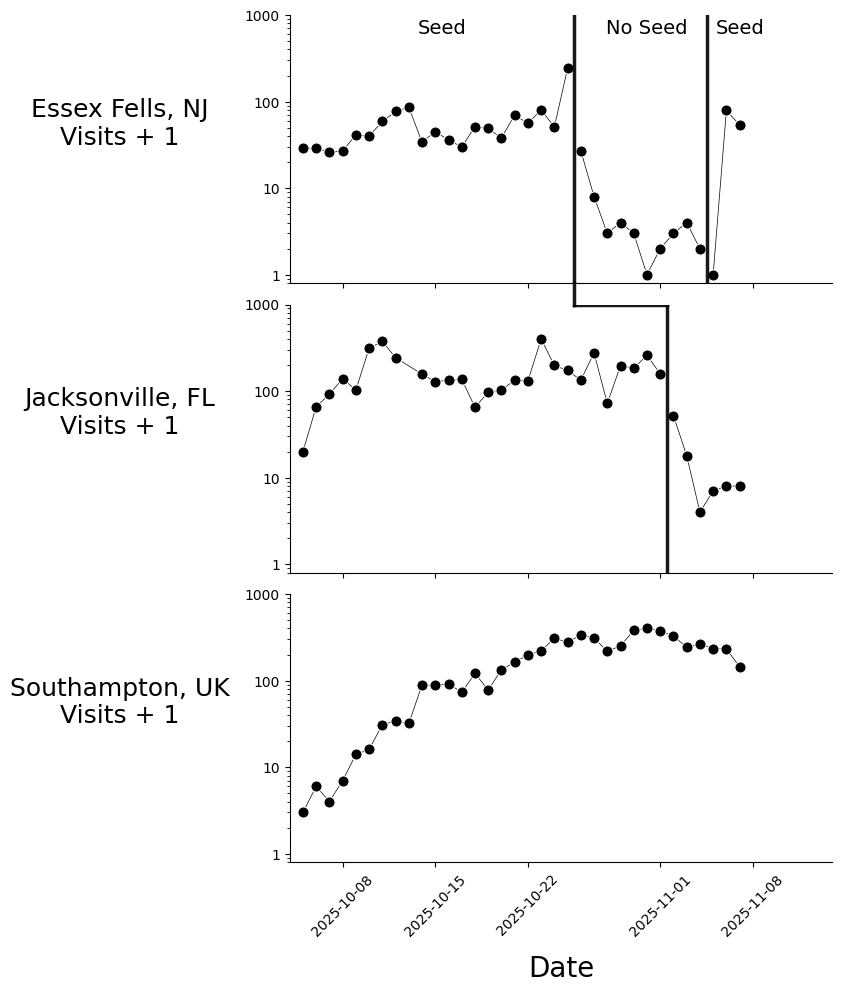

In [55]:
# ---------- Prep ----------
merged_data['Date_dt'] = pd.to_datetime(merged_data['Date_str'])
phase_changes['DateChangeStarted'] = pd.to_datetime(phase_changes['DateChangeStarted'])

regions_order = ['Essex Fells, NJ', 'Jacksonville, FL', 'Southampton, UK']

# Collect change rows per location
changes_by_loc = {
    loc: phase_changes[phase_changes['LocationOfChange'] == loc].copy().sort_values('DateChangeStarted')
    for loc in regions_order
}

def phase_midpoint(df_with_dt, change_dt):
    """
    Return the halfway datetime between the last point BEFORE change_dt and
    the first point AT/AFTER change_dt. Falls back sensibly if edges are missing.
    """
    dates = np.sort(df_with_dt['Date_dt'].dropna().unique())
    if dates.size == 0:
        return None
    left_candidates = dates[dates < change_dt]
    right_candidates = dates[dates >= change_dt]
    if left_candidates.size and right_candidates.size:
        left, right = left_candidates[-1], right_candidates[0]
    else:
        if dates.size >= 2:
            left, right = dates[-2], dates[-1]
        else:
            left = right = dates[0]
    return left + (right - left) / 2

# Compute ALL phase midpoints per region (not just the first)
all_mids_by_region = {}
primary_mid_by_region = {}
for loc in regions_order:
    rdf = merged_data[merged_data['source_sheet'] == loc].sort_values('Date_dt')
    mids = []
    if not changes_by_loc[loc].empty:
        for _, change_row in changes_by_loc[loc].iterrows():
            mid = phase_midpoint(rdf, change_row['DateChangeStarted'])
            if mid is not None:
                mids.append(mid)
        all_mids_by_region[loc] = mids
        # Keep primary_mid for backward compatibility (first change)
        primary_mid_by_region[loc] = mids[0] if mids else None
    else:
        all_mids_by_region[loc] = []
        primary_mid_by_region[loc] = None

# ---------- Phase labels configuration ----------
phase_labels = {
    'Essex Fells, NJ': {'before': 'Seed', 'after': 'No Seed'},
    # 'Jacksonville, FL': {'before': 'Seed', 'after': 'No Seed'},
    # 'Southampton, UK': {'before': 'Seed', 'after': 'No Seed'},
}

# ---------- Figure ----------
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(7, 11),
    sharex=True, gridspec_kw=dict(hspace=0.08)
)

for ax, region in zip(axes, regions_order):
    # Prepare region data (once per region)
    region_df = (
        merged_data[merged_data['source_sheet'] == region]
        .copy()
        .sort_values('Date_dt')
    )
    region_df['Feeder Visits'] = region_df['Feeder Visits'] + 1
    region_df = region_df[region_df['Date_dt'] >= pd.to_datetime('2025-10-05')]
    
    # Get date range and change info
    date_min = region_df['Date_dt'].min()
    date_max = region_df['Date_dt'].max()
    all_mids = all_mids_by_region[region]
    all_changes = changes_by_loc[region]
    
    # Plot data (split at ALL phase changes if applicable)
    if not all_changes.empty:
        # Get all change dates sorted
        change_dates = sorted(all_changes['DateChangeStarted'].tolist())
        
        # Split data at each change point
        segments = []
        if len(change_dates) > 0:
            # First segment: before first change
            segments.append(region_df[region_df['Date_dt'] < change_dates[0]])
            # Middle segments: between changes
            for i in range(len(change_dates) - 1):
                segments.append(region_df[(region_df['Date_dt'] >= change_dates[i]) & 
                                          (region_df['Date_dt'] < change_dates[i+1])])
            # Last segment: after last change
            segments.append(region_df[region_df['Date_dt'] >= change_dates[-1]])
        else:
            segments = [region_df]
        
        # Plot each segment
        for seg_df in segments:
            if not seg_df.empty:
                sns.lineplot(
                    x='Date_dt', y='Feeder Visits', data=seg_df,
                    marker='o', markersize=8, color='black', ax=ax, legend=False, 
                    linewidth=0.5
                )
    else:
        # No phase change—plot as one segment
        sns.lineplot(
            x='Date_dt', y='Feeder Visits', data=region_df,
            marker='o', markersize=8, color='black', ax=ax, legend=False, 
            linewidth=0.5
        )

    # Draw vertical lines for ALL phase changes
    for mid in all_mids:
        if mid is not None:
            ax.axvline(mid, color='black', linewidth=2.5, alpha=0.9)
    
    # Phase labels (only if configured)
    if region in phase_labels:
        y_pos_log = 700
        
        # Determine condition for each phase segment
        if not all_changes.empty:
            # Get baseline condition (before first change)
            baseline_condition = phase_labels[region].get('before', 'Seed')
            
            # Helper function to determine condition from description
            def to_condition(desc):
                desc_lower = str(desc).lower()
                if 'seed' in desc_lower and 'extinct' not in desc_lower:
                    return 'Seed'
                if 'extinct' in desc_lower or 'extinction' in desc_lower or 'no seed' in desc_lower:
                    return 'No Seed'
                return 'No Seed'
            
            # Track condition through each phase
            current_condition = baseline_condition
            change_dates = sorted(all_changes['DateChangeStarted'].tolist())
            
            # Create phase boundaries: [date_min, change1, change2, ..., date_max]
            phase_boundaries = [date_min] + change_dates + [date_max]
            
            # Label each phase segment
            for i in range(len(phase_boundaries) - 1):
                phase_start = phase_boundaries[i]
                phase_end = phase_boundaries[i + 1]
                
                # Determine condition for this phase
                if i == 0:
                    # First phase: use baseline
                    condition = baseline_condition
                else:
                    # Subsequent phases: condition changes at each boundary
                    # Find the change that happened at phase_start
                    change_at_start = all_changes[all_changes['DateChangeStarted'] == phase_start]
                    if not change_at_start.empty:
                        current_condition = to_condition(change_at_start.iloc[0]['DescriptionOfChange'])
                    condition = current_condition
                
                # Center label in this phase segment (left-align for last phase to avoid overlap)
                is_last_phase = (i == len(phase_boundaries) - 2)
                if is_last_phase:
                    # Last phase: left-align to avoid overlapping the vertical line
                    x_pos = phase_start + (phase_end - phase_start) * 0.1  # 10% into the phase
                    ax.text(x_pos, y_pos_log, condition,
                           ha='left', va='center', fontsize=14)
                else:
                    # Other phases: center the label
                    x_center = phase_start + (phase_end - phase_start) / 2
                    ax.text(x_center, y_pos_log, condition,
                           ha='center', va='center', fontsize=14)
        else:
            # No phase change - single label
            x_center = date_min + (date_max - date_min) / 2
            ax.text(x_center, y_pos_log, phase_labels[region].get('before', ''),
                   ha='center', va='center', fontsize=14)

    # Panel cosmetics
    ax.set_ylabel(f'{region}\nVisits + 1', fontsize=18, rotation=0, ha='center', labelpad=90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yscale('log')
    ax.set_ylim(0.8, 1000)
    ax.set_xlim(pd.to_datetime('2025-10-04'), region_df['Date_dt'].max() + pd.Timedelta(days=7))

# Format y-axis for all axes (moved outside the loop)
fmt = plt.matplotlib.ticker.FuncFormatter(lambda y, _: f'{int(y):d}' if y >= 1 else f'{y:g}')
for ax in axes:
    ax.yaxis.set_major_formatter(fmt)
    ax.yaxis.set_minor_formatter(plt.matplotlib.ticker.NullFormatter())

# ---------- Multi-baseline connectors (middle panel) ----------
top_mid = primary_mid_by_region['Essex Fells, NJ']
mid_mid = primary_mid_by_region['Jacksonville, FL']

if (top_mid is not None) and (mid_mid is not None):
    # Horizontal connector across the TOP of the MIDDLE panel
    x1, x2 = sorted([top_mid, mid_mid])  # left->right
    axes[1].plot(
        [x1, x2], [1, 1],
        transform=axes[1].get_xaxis_transform(),  # y in axes coords (top edge)
        color='black', linewidth=2.5, alpha=0.9
    )

    # Vertical connector from bottom of TOP panel down to TOP of MIDDLE panel at the top panel's midpoint x
    # Convert that x to figure coordinates so the line spans between axes.
    ax_top = axes[0]
    xnum_top = ax_top.convert_xunits(top_mid)                    # convert datetime -> axis units
    x_disp   = ax_top.transData.transform((xnum_top, 0))[0]      # display coords (pixels)
    x_fig    = fig.transFigure.inverted().transform((x_disp, 0))[0]  # figure fraction (0..1)

    top_bbox = axes[0].get_position()   # in figure fraction
    mid_bbox = axes[1].get_position()

    # Draw vertical segment strictly between the panels
    # from the bottom of the top axes to the top of the middle axes
    fig.lines.append(
        Line2D([x_fig, x_fig], [mid_bbox.y1, top_bbox.y0],
               transform=fig.transFigure, color='black', linewidth=2.5, alpha=0.9)
    )

# Bottom x-axis formatting
axes[-1].set_xlabel('Date', fontsize=20, labelpad=12)
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(wspace=0.8)
plt.show()

In [56]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'mbd_plot', 
    'Multiple Baseline of Feeder Visits',
    'Multiple Baseline of feeder visits across three sites'
)

Saved: Multiple Baseline of Feeder Visits -> mbd_plot


'mbd_plot'

## Calculating Daily and Weekly Diversity

In [57]:
def calculate_species_richness_by_region(daily_summs_df):
    """
    Calculate species richness (number of unique species) per day per region.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', 'source_sheet', ...]
    
    Returns:
    DataFrame with Date, source_sheet, and richness columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    daily = daily[daily['Feeder Visits'] > 0].reset_index(drop=True)
    richness = daily.groupby(["Date", "source_sheet"])["Bird"].nunique().reset_index()
    richness.columns = ['Date', 'source_sheet', 'richness']
    
    return richness

def calculate_shannon_h_by_region(daily_summs_df):
    """
    Calculate Shannon H (alpha diversity) per day per region.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', 'source_sheet', ...]
    
    Returns:
    DataFrame with Date, source_sheet, and shannon_H columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    # Create pivot table: dates and regions as rows, bird species as columns, feeder visits as values
    day_species = daily.pivot_table(
        index=["Date", "source_sheet"], 
        columns="Bird", 
        values="Feeder Visits", 
        aggfunc="sum", 
        fill_value=0
    )
    
    # Calculate proportions (relative abundance) for each species on each day/region
    # Replace 0 with NaN to avoid log(0) issues
    p = day_species.div(day_species.sum(axis=1), axis=0).replace(0, np.nan)
    
    # Calculate Shannon H: -sum(p * log(p))
    shannon = (-(p * np.log(p)).sum(axis=1)).reset_index()
    shannon.columns = ['Date', 'source_sheet', 'shannon_H']
    
    return shannon

def calculate_weekly_sorensen_dissimilarity_by_region(daily_summs_df):
    """
    Calculate Sørensen dissimilarity between consecutive weeks per region.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', 'source_sheet', ...]
    
    Returns:
    DataFrame with Date, source_sheet, and sorensen_dissimilarity columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    daily['week'] = daily['Date'].dt.isocalendar().week
    
    # Create weekly presence/absence matrix per region
    weekly_presence = (daily.groupby(["week", "source_sheet", "Bird"])["Feeder Visits"]
                       .sum().unstack(fill_value=0) > 0).astype(int)
    
    # Calculate Sørensen dissimilarity between consecutive weeks for each region
    sorensen = []
    
    for region in daily['source_sheet'].unique():
        region_data = daily[daily['source_sheet'] == region]
        region_weeks = sorted(region_data['week'].unique())
        
        for w_prev, w_curr in zip(region_weeks[:-1], region_weeks[1:]):
            try:
                a = weekly_presence.loc[(w_prev, region)]  # Previous week species presence
                b = weekly_presence.loc[(w_curr, region)]  # Current week species presence
                
                a_sum = a.sum()  # Number of species in previous week
                b_sum = b.sum()  # Number of species in current week
                intersection = (a & b).sum()  # Number of species in both weeks
                
                # Sørensen dissimilarity formula: 1 - (2 * intersection) / (a_sum + b_sum)
                denom = (a_sum + b_sum)
                d_s = np.nan if denom == 0 else 1 - (2 * intersection / denom)
                
                sorensen.append({
                    "week": w_curr, 
                    "source_sheet": region,
                    "sorensen_dissimilarity": d_s
                })
            except KeyError:
                continue
    
    # Convert to DataFrame
    beta_df = pd.DataFrame(sorensen)
    
    # Get all dates and their weeks per region
    all_dates = daily[['Date', 'week', 'source_sheet']].drop_duplicates().sort_values(['source_sheet', 'Date'])
    
    # Merge with Sørensen dissimilarity data
    result_df = all_dates.merge(beta_df, on=['week', 'source_sheet'], how='left')
    result_df = result_df[['Date', 'source_sheet', 'sorensen_dissimilarity']]
    
    return result_df

def calculate_rolling_sorensen_dissimilarity_by_region(daily_summs_df):
    """
    Calculate Sørensen dissimilarity using rolling 3-day comparisons per region.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', 'source_sheet', ...]
    
    Returns:
    DataFrame with Date, source_sheet, and rolling_sorensen_dissimilarity columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    sorensen_results = []
    
    # Process each region separately
    for region in daily['source_sheet'].unique():
        region_data = daily[daily['source_sheet'] == region].sort_values('Date').reset_index(drop=True)
        
        # Create daily presence/absence matrix for this region
        daily_presence = (region_data.groupby(["Date", "Bird"])["Feeder Visits"]
                          .sum().unstack(fill_value=0) > 0).astype(int)
        
        # Get sorted dates for this region
        dates_sorted = sorted(daily_presence.index)
        
        # Calculate rolling 3-day Sørensen dissimilarity
        for i in range(len(dates_sorted)):
            current_date = dates_sorted[i]
            
            # Define the two 3-day periods to compare
            period_a_dates = []
            period_b_dates = []
            
            # Get dates for period A (7-9 days ago)
            for offset in [9, 8, 7]:
                if i - offset >= 0:
                    period_a_dates.append(dates_sorted[i - offset])
            
            # Get dates for period B (0-2 days ago)
            for offset in [2, 1, 0]:
                if i - offset >= 0:
                    period_b_dates.append(dates_sorted[i - offset])
            
            # Only calculate if we have at least one date in each period
            if len(period_a_dates) > 0 and len(period_b_dates) > 0:
                # Get species presence for each period
                period_a_presence = daily_presence.loc[period_a_dates].any(axis=0)
                period_b_presence = daily_presence.loc[period_b_dates].any(axis=0)
                
                # Calculate Sørensen dissimilarity
                a_sum = period_a_presence.sum()
                b_sum = period_b_presence.sum()
                intersection = (period_a_presence & period_b_presence).sum()
                
                # Sørensen dissimilarity formula: 1 - (2 * intersection) / (a_sum + b_sum)
                denom = (a_sum + b_sum)
                d_s = np.nan if denom == 0 else 1 - (2 * intersection / denom)
                
                sorensen_results.append({
                    'Date': current_date,
                    'source_sheet': region,
                    'rolling_sorensen_dissimilarity': d_s
                })
            else:
                sorensen_results.append({
                    'Date': current_date,
                    'source_sheet': region,
                    'rolling_sorensen_dissimilarity': np.nan
                })
    
    # Create result DataFrame
    result_df = pd.DataFrame(sorensen_results)
    
    return result_df

# Calculate each metric separately
richness_df = calculate_species_richness_by_region(daily_summs)
shannon_df = calculate_shannon_h_by_region(daily_summs)
weekly_sorensen_df = calculate_weekly_sorensen_dissimilarity_by_region(daily_summs)
rolling_sorensen_df = calculate_rolling_sorensen_dissimilarity_by_region(daily_summs)

# Merge all metrics into a single dataframe
diversity_metrics_clean = richness_df.merge(shannon_df, on=['Date', 'source_sheet'], how='outer')
diversity_metrics_clean = diversity_metrics_clean.merge(weekly_sorensen_df, on=['Date', 'source_sheet'], how='outer')
diversity_metrics_clean = diversity_metrics_clean.merge(rolling_sorensen_df, on=['Date', 'source_sheet'], how='outer')

# Sort by date and region
diversity_metrics_clean = diversity_metrics_clean.sort_values(['source_sheet', 'Date']).reset_index(drop=True)

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/3328956252.py:195: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/3328956252.py:195: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/3328956252.py:195: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_9570/3328956252.py:195: UserWarning: No artists with labels found to put in legend.  Note that artists whose labe

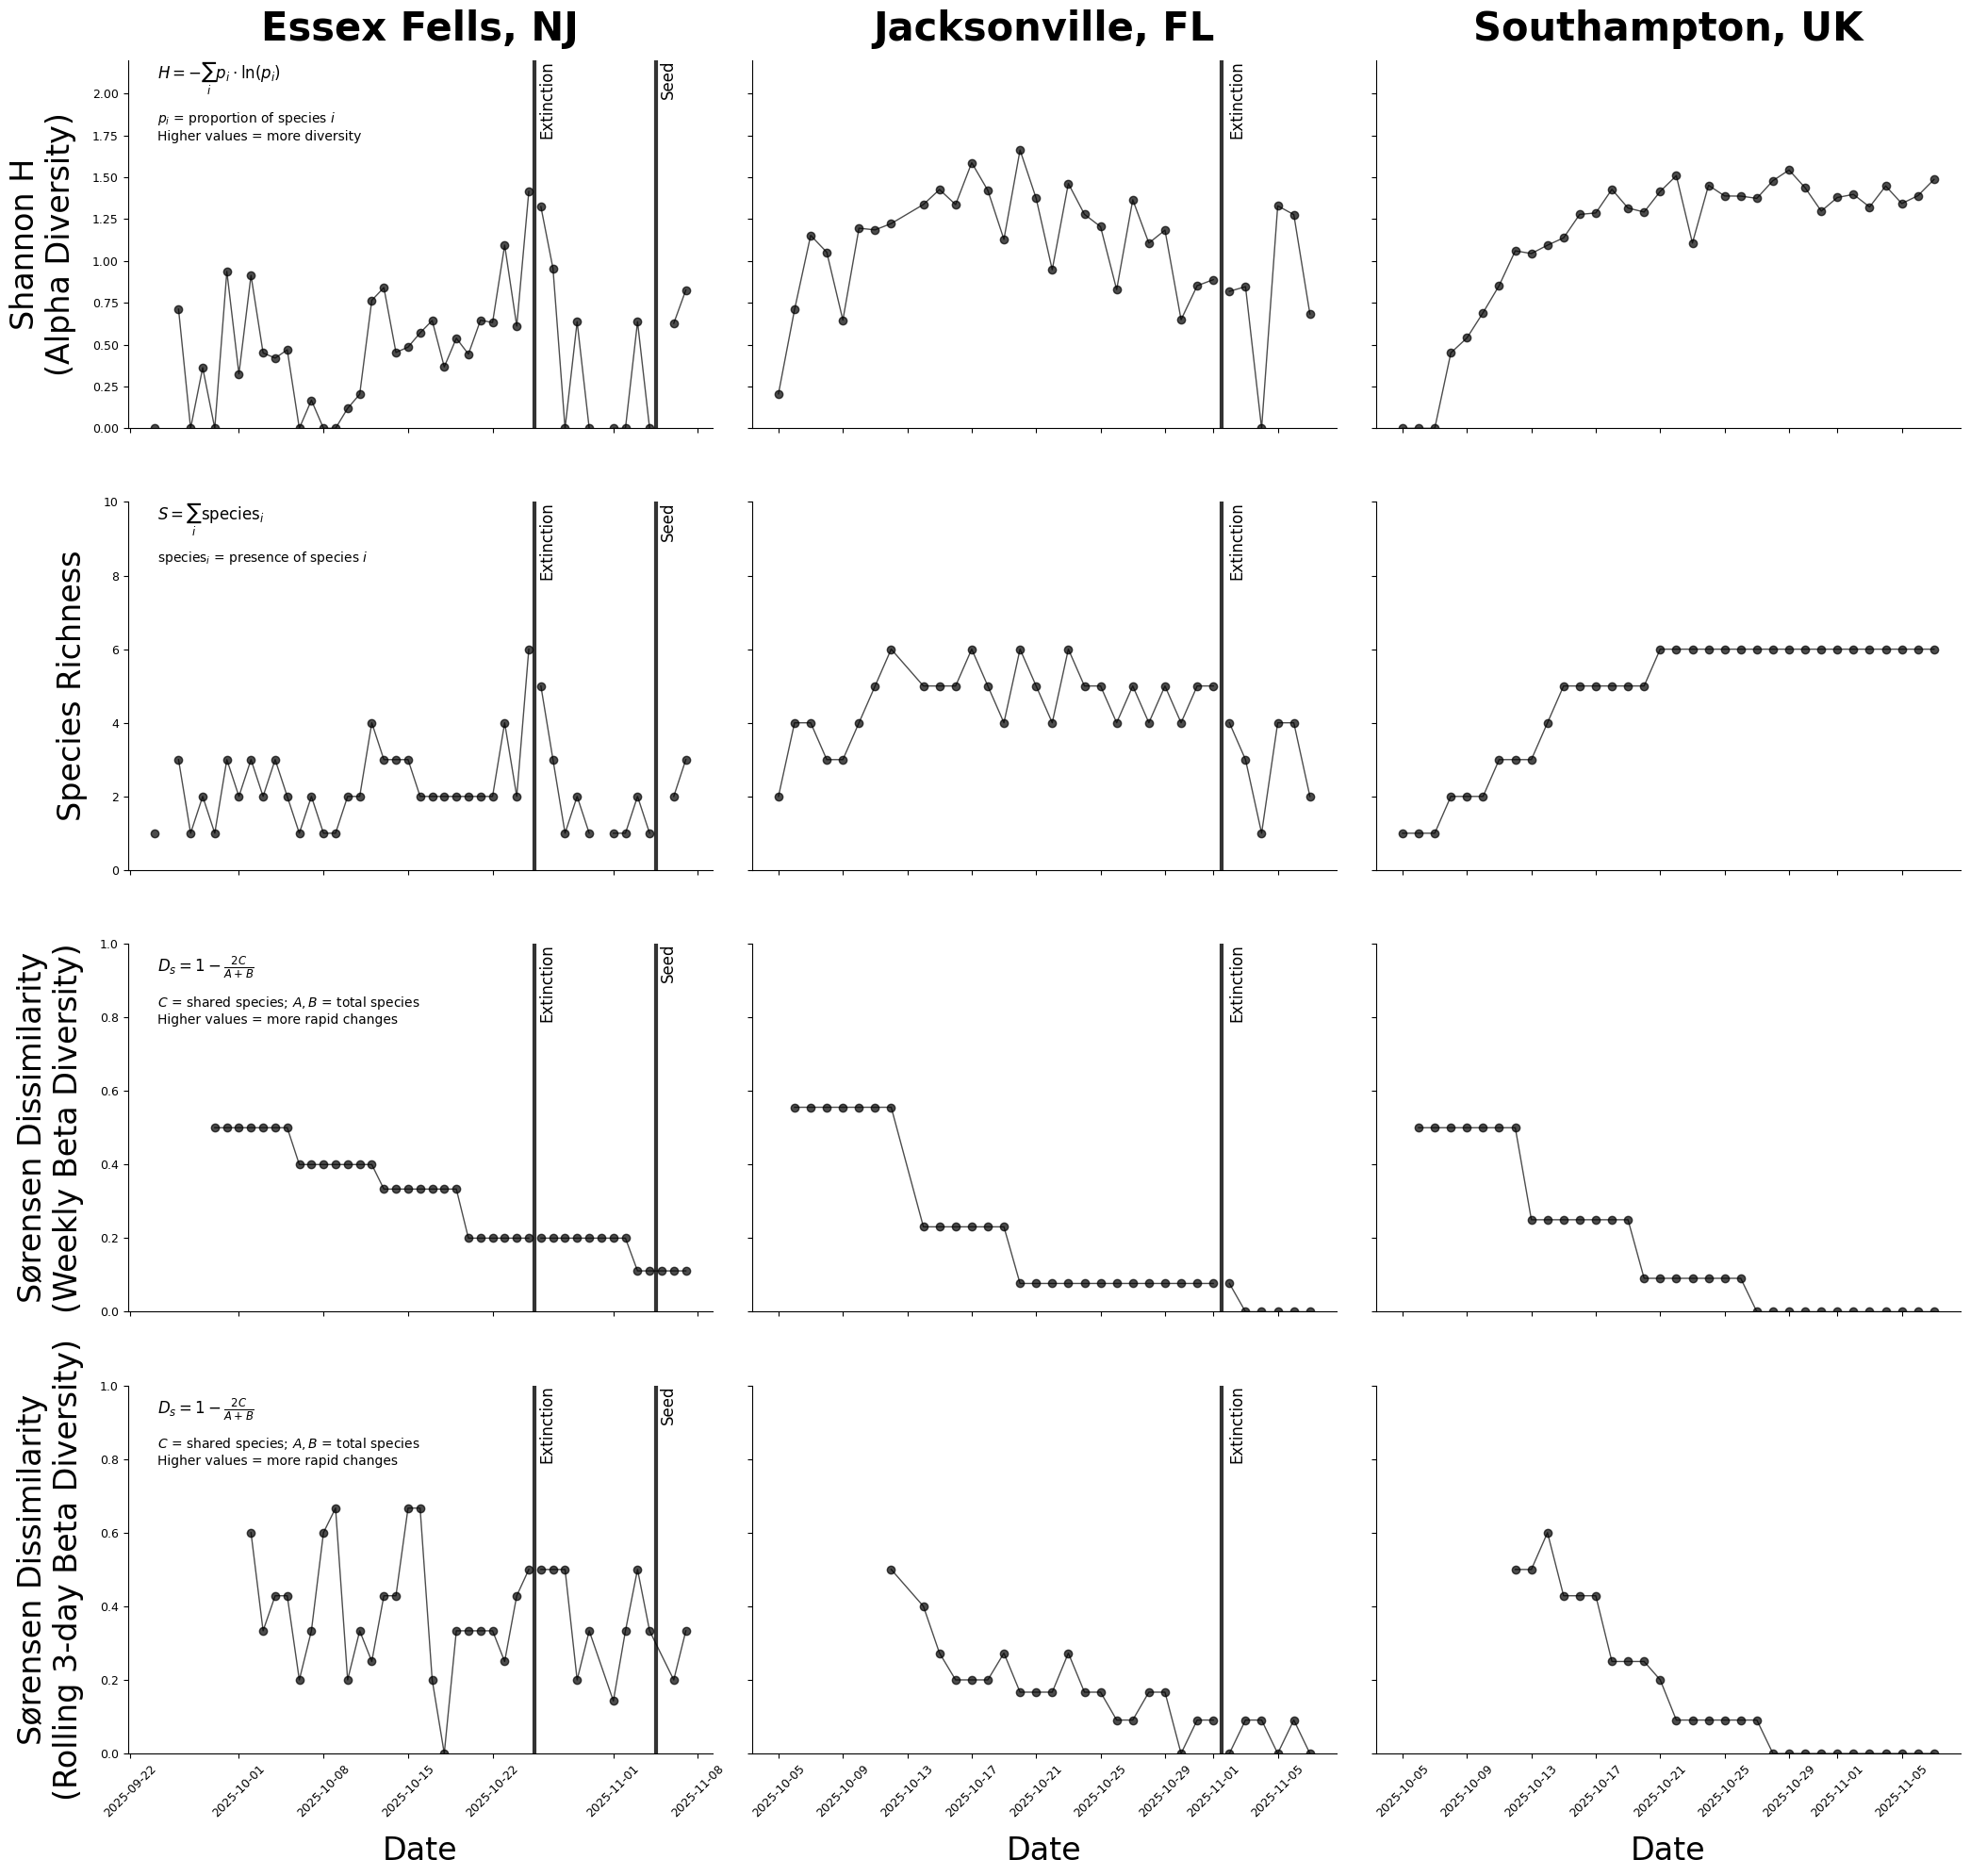

In [58]:
# Get unique locations
locations = sorted(diversity_metrics_clean['source_sheet'].unique())
n_locations = len(locations)

# Create 4x3 subplot layout (4 rows for metrics, 3 columns for locations)
fig, axes = plt.subplots(4, n_locations, figsize=(7*n_locations, 20), sharex='col', sharey='row')

# Ensure axes is always a 2D array for consistent indexing
if n_locations == 1:
    axes = axes.reshape(4, 1)

# Define plot configurations (one per metric/row)
plot_configs = [
    {
        'row_idx': 0,
        'y_col': 'shannon_H',
        'title': 'Species Diversity Within Each Day',
        'ylabel': 'Shannon H\n(Alpha Diversity)',
        'show_legend': True,
        'equation': r'$H = -\sum_{i} p_i \cdot \ln(p_i)$',
        'description': '$p_i$ = proportion of species $i$\nHigher values = more diversity',
        'eq_pos': (0.05, 0.90),
        'desc_pos': (0.05, 0.775),
        'eq_align': 'left', 
        'ylim': (0, 2.2)
    },
    {
        'row_idx': 1,
        'y_col': 'richness',
        'title': 'Number of Unique Species Per Day',
        'ylabel': 'Species Richness',
        'show_legend': False,
        'equation': r'$S = \sum_{i} \text{species}_i$',
        'description': r'$\text{species}_i$ = presence of species $i$',
        'eq_pos': (0.05, 0.9),
        'desc_pos': (0.05, 0.825),
        'eq_align': 'left', 
        'ylim': (0, 10)
    },
    {
        'row_idx': 2,
        'y_col': 'sorensen_dissimilarity',
        'title': 'Species Turnover Between Weeks',
        'ylabel': 'Sørensen Dissimilarity\n(Weekly Beta Diversity)',
        'show_legend': False,
        'equation': r'$D_s = 1 - \frac{2C}{A + B}$',
        'description': '$C$ = shared species; $A,B$ = total species\nHigher values = more rapid changes',
        'eq_pos': (0.05, 0.9),
        'desc_pos': (0.05, 0.775),
        'eq_align': 'left',
        'ylim': (0, 1),
        'data_filter': lambda df: df.dropna(subset=['sorensen_dissimilarity'])
    },
    {
        'row_idx': 3,
        'y_col': 'rolling_sorensen_dissimilarity',
        'title': 'Species Turnover (Rolling 3-day)',
        'ylabel': 'Sørensen Dissimilarity\n(Rolling 3-day Beta Diversity)',
        'show_legend': False,
        'equation': r'$D_s = 1 - \frac{2C}{A + B}$',
        'description': '$C$ = shared species; $A,B$ = total species\nHigher values = more rapid changes',
        'eq_pos': (0.05, 0.9),
        'desc_pos': (0.05, 0.775),
        'eq_align': 'left',
        'ylim': (0, 1),
        'data_filter': lambda df: df.dropna(subset=['rolling_sorensen_dissimilarity'])
    }
]

# Plot all subplots: iterate over metrics (rows) and locations (columns)
for config in plot_configs:
    row_idx = config['row_idx']
    
    # Filter data if needed (for the entire metric)
    plot_data = config.get('data_filter', lambda df: df)(diversity_metrics_clean)
    
    for col_idx, location in enumerate(locations):
        ax = axes[row_idx, col_idx]
        
        # Get data for this location and metric
        location_data = plot_data[plot_data['source_sheet'] == location].copy()
        
        # Check for phase changes for this location
        location_phase_changes = phase_changes[phase_changes['LocationOfChange'] == location]
        
        # Get the phase change date if it exists
        phase_change_date = None
        if not location_phase_changes.empty:
            phase_change_date = pd.to_datetime(location_phase_changes.iloc[0]['DateChangeStarted'])
            description = location_phase_changes.iloc[0]['DescriptionOfChange']
        
        if not location_data.empty and location_data[config['y_col']].notna().any():
            # Ensure Date is datetime
            location_data['Date'] = pd.to_datetime(location_data['Date'])
            location_data = location_data.sort_values('Date')
            
            # Split data at phase change if it exists
            if phase_change_date is not None:
                before_change = location_data[location_data['Date'] < phase_change_date]
                after_change = location_data[location_data['Date'] >= phase_change_date]
                
                # Plot before phase change
                if not before_change.empty and before_change[config['y_col']].notna().any():
                    ax.plot(
                        before_change['Date'], 
                        before_change[config['y_col']], 
                        marker='o', 
                        markersize=6,
                        linewidth=1, 
                        alpha=0.7,
                        color='black',
                        label=location if row_idx == 0 and col_idx == 0 and config['show_legend'] else ""
                    )
                
                # Plot after phase change
                if not after_change.empty and after_change[config['y_col']].notna().any():
                    ax.plot(
                        after_change['Date'], 
                        after_change[config['y_col']], 
                        marker='o', 
                        markersize=6,
                        linewidth=1, 
                        alpha=0.7,
                        color='black',
                        label=""
                    )
            else:
                # No phase change, plot normally
                ax.plot(
                    location_data['Date'], 
                    location_data[config['y_col']], 
                    marker='o', 
                    markersize=6,
                    linewidth=1, 
                    alpha=0.7,
                    color='black',
                    label=location if row_idx == 0 and col_idx == 0 and config['show_legend'] else ""
                )
            
            # Add phase change vertical lines for this location
            for _, phase_row in location_phase_changes.iterrows():
                change_date = pd.to_datetime(phase_row['DateChangeStarted'])
                description = phase_row['DescriptionOfChange']
                
                # Find the date before the change date
                location_dates = location_data['Date'].unique()
                location_dates = pd.to_datetime(location_dates)
                location_dates = np.sort(location_dates)
                
                # Find the date before the change date
                before_change_idx = np.where(location_dates < change_date)[0]
                if len(before_change_idx) > 0:
                    date_before = location_dates[before_change_idx[-1]]
                    # Calculate halfway point
                    halfway_date = date_before + (change_date - date_before) / 2
                    
                    # Add vertical line
                    ax.axvline(x=halfway_date, color='black', linestyle='-', linewidth=3, alpha=0.8)
                    
                    # Add description text
                    ymax = location_data[config['y_col']].max()
                    if 'ylim' in config:
                        ylim_max = config['ylim'][1]
                    else:
                        ylim_max = ax.get_ylim()[1]
                    ax.text(halfway_date + pd.Timedelta(days=1), ylim_max, description, 
                        rotation=90, ha='center', va='top', fontsize=12)
            
            # Set labels
            if col_idx == 0:
                ax.set_ylabel(config['ylabel'], fontsize=24, labelpad=12)
            else:
                ax.set_ylabel('')
            
            if row_idx == len(plot_configs) - 1:
                ax.set_xlabel('Date', fontsize=24, labelpad=12)
            else:
                ax.set_xlabel('')
            
            # Set title
            if row_idx == 0:
                # Top row: location names as column headers
                ax.set_title(location, fontsize=30, fontweight='bold', pad=15)
            # elif col_idx == 0:
            #     # First column: metric titles as row labels
            #     ax.set_title(config['title'], fontsize=12, fontweight='bold', pad=15)
            else:
                ax.set_title('')
            
            # Set y-axis limits if specified
            if 'ylim' in config:
                ax.set_ylim(config['ylim'])
            
            # Remove legend
            ax.legend().remove()
            
            # Add equation and description (only for first column)
            if col_idx == 0:
                ax.text(config['eq_pos'][0], config['eq_pos'][1], config['equation'], 
                       transform=ax.transAxes, fontsize=12, 
                       ha=config['eq_align'], va='bottom')
                ax.text(config['desc_pos'][0], config['desc_pos'][1], config['description'], 
                       transform=ax.transAxes, fontsize=10, 
                       ha=config['eq_align'], va='bottom')
        else:
            # Show "no data" message
            ax.text(0.5, 0.5, f'No {config["y_col"]} data available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            # Set title
            if row_idx == 0:
                ax.set_title(location, fontsize=12, fontweight='bold', pad=15)
            # elif col_idx == 0:
            #     ax.set_title(config['title'], fontsize=12, fontweight='bold', pad=15)
            else:
                ax.set_title('')
        
        # Apply styling
        sns.despine(top=True, right=True, ax=ax)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.show()

In [59]:
# Save diversity metrics plot for dashboard
save_plot_for_dashboard(
    fig, 
    'diversity_metrics', 
    'Ecological Diversity Metrics',
    'Shannon H diversity and species richness metrics over time'
)

Saved: Ecological Diversity Metrics -> diversity_metrics


'diversity_metrics'